# Forecasting Agricultural Trade Growth in Emerging Economies Using Machine Learning

**Student Name:** Soundarya Mattikatti

**Student Number:** 20040870

## Introduction

The study investigated the prediction of agricultural trade flows between countries through the application of machine learning and interpretable modeling techniques. It commenced with the collection and cleaning of global datasets on agricultural imports, exports, and key economic indicators. The data were subsequently preprocessed to ensure consistency, eliminate incomplete records, and integrate trade statistics with country-level economic variables.

In addition, the study incorporated the engineering of novel features, including lagged trade values, moving averages, and trend components, in order to capture temporal dynamics and the influence of economic conditions on trade patterns. Several machine learning algorithms, such as ExtraTrees, RandomForest, and Explainable Boosting Machines (EBM), were trained to forecast future agricultural imports and exports at the country level. Model performance was evaluated using standard statistical metrics, including mean absolute error (MAE), root mean squared error (RMSE), and the coefficient of determination (R²). Furthermore, the interpretability of the models was enhanced through the use of feature importance rankings and SHAP value analyses.

Following validation, the models were employed to generate five-year forecasts of agricultural trade. The analysis of these projections highlighted countries expected to experience the most rapid growth in imports and exports, as well as those likely to achieve improvements in their net trade balances. Overall, the findings provided a comprehensive, data-driven perspective on global agricultural trade trajectories and underscored the potential of integrating advanced machine learning approaches with transparent, interpretable modeling frameworks.

## Table of Contents
- <a href="#knowing-the-dataset">Knowing the dataset</a>
- <a href="#data-preprocessing">Data preprocessing</a>
- <a href="#eda-section">Exploratory Data Analysis (EDA)</a>
- <a href="#feature-engineering">Feature Engineering</a>
- <a href="#model-input-preparation">Model Input Preparation</a>
- <a href="#baseline-models-training-and-comparison">Model Training and Evaluation </a>
- <a href="#hyperparameter-tuning">Hyperparameter Tuning</a>
- <a href="#model-interpretation">Model Interpretation</a>
- <a href="#inference">Inference</a>
- <a href="#conclusion">Conclusion</a>




### Importing Essential Libraries

The study employed Python libraries to support data analysis and modeling. Pandas and NumPy were used for data manipulation, Matplotlib and Seaborn for visualization, and scikit-learn for machine learning. Additionally, InterpretML and SHAP facilitated model interpretability.

In [ ]:
import glob
import pickle
import datetime
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from category_encoders import TargetEncoder
from scipy.stats import randint

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap
from prophet import Prophet
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

import warnings
warnings.filterwarnings('ignore')

/home/sid/my_stuff/python-envs/py-3.12-base-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Knowing the dataset

### Loading the Raw Agricultural Trade Dataset  

The agricultural trade dataset was imported from a CSV file (`merchandise_values_annual_dataset.csv`) using **Pandas**.  
To verify successful loading, the dataset’s shape was displayed along with the first few rows.  
This ensured that the data were correctly read into memory and provided an initial view of its structure.  

In [2]:
df_raw = pd.read_csv('data/merchandise_values_annual_dataset.csv', encoding='latin-1')

print(f"Data loaded with shape: {df_raw.shape}")
df_raw.head()

Data loaded with shape: (232164, 23)


,IndicatorCategory,IndicatorCode,Indicator,ReporterCode,ReporterISO3A,Reporter,PartnerCode,PartnerISO3A,Partner,ProductClassificationCode,...,PeriodCode,Period,FrequencyCode,Frequency,UnitCode,Unit,Year,ValueFlagCode,ValueFlag,Value
0,Merchandise trade values,ITS_MTV_AM,Merchandise imports by product group - annual,484,MEX,Mexico,000,NaN,World,SITC3,...,A,Annual,A,Annual,USM,Million US dollar,1980,NaN,NaN,3744
1,Merchandise trade values,ITS_MTV_AM,Merchandise imports by product group - annual,372,IRL,Ireland,000,NaN,World,SITC3,...,A,Annual,A,Annual,USM,Million US dollar,2006,NaN,NaN,7108
2,Merchandise trade values,ITS_MTV_AM,Merchandise imports by product group - annual,524,NPL,Nepal,000,NaN,World,SITC3,...,A,Annual,A,Annual,USM,Million US dollar,2020,NaN,NaN,2335
3,Merchandise trade values,ITS_MTV_AM,Merchandise imports by product group - annual,100,BGR,Bulgaria,000,NaN,World,SITC3,...,A,Annual,A,Annual,USM,Million US dollar,2015,NaN,NaN,3267
4,Merchandise trade values,ITS_MTV_AM,Merchandise imports by product group - annual,484,MEX,Mexico,000,NaN,World,SITC3,...,A,Annual,A,Annual,USM,Million US dollar,1981,NaN,NaN,3622


Displaying comprehensive dataset information including data types, null values

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232164 entries, 0 to 232163
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   IndicatorCategory          232164 non-null  object
 1   IndicatorCode              232164 non-null  object
 2   Indicator                  232164 non-null  object
 3   ReporterCode               232164 non-null  object
 4   ReporterISO3A              222409 non-null  object
 5   Reporter                   232164 non-null  object
 6   PartnerCode                232164 non-null  object
 7   PartnerISO3A               866 non-null     object
 8   Partner                    232164 non-null  object
 9   ProductClassificationCode  232164 non-null  object
 10  ProductClassification      232164 non-null  object
 11  ProductCode                232164 non-null  object
 12  Product                    232164 non-null  object
 13  PeriodCode                 232164 non-null  

Examining unique values in key categorical columns to understand data structure and categories

In [5]:
for col in ['Product', 'Indicator', 'Period', 'Frequency', 'Unit', 'Reporter']:
    print(f"Unique values in '{col}': \n{df_raw[col].unique()}")
    print("-" * 50)

Unique values in 'Product': 
['Agricultural products' 'Food' 'Manufactures' 'Chemicals'
 'Pharmaceuticals' 'Clothing' 'Iron and steel'
 'Machinery and transport equipment' 'Automotive products'
 'Office and telecom equipment'
 'Electronic data processing and office equipment'
 'Integrated circuits and electronic components'
 'Telecommunications equipment' 'Transport equipment' 'Textiles'
 'Fuels and mining products' 'Fuels' 'Total merchandise']
--------------------------------------------------
Unique values in 'Indicator': 
['Merchandise imports by product group - annual'
 'Merchandise exports by product group - annual']
--------------------------------------------------
Unique values in 'Period': 
['Annual']
--------------------------------------------------
Unique values in 'Frequency': 
['Annual']
--------------------------------------------------
Unique values in 'Unit': 
['Million US dollar']
--------------------------------------------------
Unique values in 'Reporter': 
['Mexic

Analyzing missing data patterns across all columns to identify data quality issues

In [6]:
print("=== MISSING DATA ANALYSIS ===")
missing_data = df_raw.isnull().sum()
missing_pct = (missing_data / len(df_raw) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

=== MISSING DATA ANALYSIS ===
               Missing_Count  Missing_Percentage
PartnerISO3A          231298                99.6
ValueFlag             220335                94.9
ValueFlagCode         220335                94.9
ReporterISO3A           9755                 4.2


Reveals critical data quality issues with 99.6% missing partner data and 94.9% missing value flags, indicating the need for careful handling of missing values in subsequent analysis

## Data preprocessing

## To prepare the dataset for analysis and modeling, several preprocessing steps were applied:  

1. **Dataset Copy** – A working copy of the raw dataset was created to preserve the original file.  
2. **Trade Type Classification** – A new column (`TradeType`) was introduced to distinguish between *Imports* and *Exports* by parsing the `Indicator` field.  
3. **Country Name Standardization** – Variations in country names (e.g., “Russian Federation” → “Russia”, “Korea, Rep.” → “South Korea”) were mapped to standardized names to ensure consistency.  
4. **Entity Categorization** – Non-country entities such as regions, economic groups, and historical entities were tagged separately in `ReporterEntityType` to allow filtering for valid countries.  
5. **Column Selection** – Only essential columns relevant to trade analysis were retained, excluding redundant metadata.  
6. **Pivot Transformation** – The dataset was reshaped into a structured format with separate columns for product–trade type combinations, allowing country–year level analysis.  


In [7]:
data = df_raw.copy()

In [8]:
data['TradeType'] = data['Indicator'].apply(lambda x: 'Import' if 'imports' in x.lower() else 'Export')

In [9]:
reporter_name_standardized_map = {
    # Official Titles -> Common Name
    'Bolivia, Plurinational State of': 'Bolivia',
    'Bahrain, Kingdom of': 'Bahrain',
    'Brunei Darussalam': 'Brunei',
    'Kuwait, the State of': 'Kuwait',
    'Saudi Arabia, Kingdom of': 'Saudi Arabia',
    'Venezuela, Bolivarian Republic of': 'Venezuela',
    "Lao People's Democratic Republic": 'Laos',
    'Lebanese Republic': 'Lebanon',
    'Syrian Arab Republic': 'Syria',
    'Moldova, Republic of': 'Moldova',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',

    # Common Name Discrepancies
    'Chinese Taipei': 'Taiwan',
    'Congo': 'Republic of the Congo',
    'The Gambia': 'Gambia',
    'Korea, Republic of': 'South Korea',
    "Korea, Democratic People's Republic of": 'North Korea',
    'United States of America': 'United States',
    'Micronesia, Federated States of': 'Micronesia',

    # Special Characters / Punctuation
    "Côte d'Ivoire": "Cote d'Ivoire",
    'Türkiye': 'Turkey',
    'Sao Tomé and Principe': 'Sao Tome and Principe',

    # Component Parts / Associated States
    'Hong Kong, China': 'Hong Kong',
    'Macao, China': 'Macao',
    'Netherlands, Kingdom of, with respect to Aruba': 'Aruba',
    'Ethiopia (+ Eritrea)': 'Ethiopia and Eritrea', # Represents combined data
}

data['Reporter'] = data['Reporter'].replace(reporter_name_standardized_map)

In [10]:
entity_categorization_map = {
    # --- Economic & Regional Groups ---
    'African, Caribbean and Pacific States (ACP)': 'Economic Group',
    'Africa, CIS and Middle East': 'Geographic Region',
    'Andean Community (ANDEAN)': 'Economic Group',
    'Asia': 'Geographic Region',
    'Asia-Pacific Economic Cooperation (APEC)': 'Economic Group',
    'Association of Southeast Asian Nations (ASEAN)': 'Economic Group',
    'Australia and New Zealand': 'Geographic Region',
    'Belgium-Luxembourg': 'Historical Economic Union',
    'BRIC members': 'Economic Group',
    'BRICS members': 'Economic Group',
    'Caribbean Community (CARICOM)': 'Economic Group',
    'Central African Economic and Monetary Community (CAEMC)': 'Economic Group',
    'Central American Common Market (CACM)': 'Economic Group',
    'Commonwealth of Independent States (CIS), including certain associate and former member States': 'Economic Group',
    'Common Market for Eastern and Southern Africa (COMESA)': 'Economic Group',
    'ECCAS (Economic Community of Central African States)': 'Economic Group',
    'Euro Area (20)': 'Economic Group',
    'Europe': 'Geographic Region',
    'European Free Trade Association (EFTA)': 'Economic Group',
    'European Union': 'Economic/Political Union',
    'Four East Asian traders': 'Economic Group',
    'G-7 (Group of Seven)': 'Political Group',
    'G-20': 'Political Group',
    'Gulf Cooperation Council (GCC)': 'Economic Group',
    'Landlocked developing countries': 'Economic Group',
    'LDC exporters of agriculture': 'Economic Group',
    'LDC exporters of manufactures': 'Economic Group',
    'LDC non-fuel mineral exporters': 'Economic Group',
    'LDC oil exporters': 'Economic Group',
    'Least-developed countries': 'Economic Group',
    'Middle East': 'Geographic Region',
    'Non-EU south-eastern Europe': 'Geographic Region',
    'Non-EU western Europe': 'Geographic Region',
    'North America': 'Geographic Region',
    'OIC (Organisation of Islamic Cooperation)': 'Political Group',
    'OPEC (Organization of the Petroleum Exporting Countries)': 'Economic Group',
    'Other Africa': 'Geographic Region',
    'Other Asia': 'Geographic Region',
    'Other CIS': 'Geographic Region',
    'Pacific Alliance': 'Economic Group',
    'Six East Asian traders': 'Economic Group',
    'South and Central America and the Caribbean': 'Geographic Region',
    'South Asian Association for Regional Cooperation (SAARC)': 'Economic Group',
    'Southern African Development Community (SADC)': 'Economic Group',
    'Southern Common Market (MERCOSUR) excluding Venezuela, Bolivarian Republic of': 'Economic Group',
    'United States-Mexico-Canada Agreement (USMCA/CUSMA/T-MEC)': 'Economic Group',
    'West African Economic Community (ECOWAS)': 'Economic Group',
    'West African Economic and Monetary Union (WAEMU)': 'Economic Group',
    'WTO Members': 'Trade Group',
    'WTO Observer governments': 'Trade Group',

    # --- Historical Entities ---
    'Czech and Slovak Federal Republic': 'Historical Entity',
    'German Democratic Republic': 'Historical Entity',
    'Germany, Federal Republic of': 'Historical Entity',
    'Netherlands Antilles': 'Historical Entity',
    'Netherlands Antilles (incl. Aruba)': 'Historical Entity',
    'Serbia and Montenegro': 'Historical Entity',
    'U.S.S.R.': 'Historical Entity',
    "Yemen, People's Democratic Republic": 'Historical Entity',
    'Yemen, Arab Republic of': 'Historical Entity',
    'Yugoslavia, Socialist Federal Republic of': 'Historical Entity',

    # --- Territories & Dependencies ---
    'American Samoa': 'Territory/Dependency',
    'Anguilla': 'Territory/Dependency',
    'Bermuda': 'Territory/Dependency',
    'Bonaire, Sint Eustatius and Saba': 'Territory/Dependency',
    'Cayman Islands': 'Territory/Dependency',
    'Cook Islands': 'Territory/Dependency',
    'Curaçao': 'Territory/Dependency',
    'French Guiana': 'Territory/Dependency',
    'French Polynesia': 'Territory/Dependency',
    'French Southern Territories': 'Territory/Dependency',
    'Gibraltar': 'Territory/Dependency',
    'Greenland': 'Territory/Dependency',
    'Guadeloupe': 'Territory/Dependency',
    'Guam': 'Territory/Dependency',
    'Martinique': 'Territory/Dependency',
    'Montserrat': 'Territory/Dependency',
    'New Caledonia': 'Territory/Dependency',
    'Niue': 'Territory/Dependency',
    'Northern Mariana Islands': 'Territory/Dependency',
    'Reunion': 'Territory/Dependency',
    'Saint Pierre and Miquelon': 'Territory/Dependency',
    'Sint Maarten': 'Territory/Dependency',
    'Tokelau': 'Territory/Dependency',
    'Turks and Caicos Islands': 'Territory/Dependency',
    'Wallis and Futuna Islands': 'Territory/Dependency',

    # --- Aggregates & Continents ---
    'World': 'Aggregate',
    'Africa': 'Geographic Region',
}

data['ReporterEntityType'] = data['Reporter'].map(entity_categorization_map)
data['ReporterEntityType'] = data['ReporterEntityType'].fillna('Country')

In [11]:
essential_columns = [
    'Reporter',
    'ReporterISO3A',
    'ReporterEntityType',
    'Partner',
    'PartnerISO3A',
    'Year',
    'Value',
    'Unit',
    'ValueFlag',
    'Product',
    'TradeType'
]

data = data[essential_columns]

In [ ]:
data = data.sort_values(by=['Year', 'Reporter'])

pivoted_data = data.pivot_table(
    index=['Reporter', 'ReporterEntityType', 'Year'],
    columns=['Product', 'TradeType'],
    values='Value',
    aggfunc='sum'
).reset_index()

pivoted_data.columns = [f"{col[0].replace(' ', '_')}_{col[1]}" if isinstance(col, tuple) else col for col in pivoted_data.columns]

pivoted_data.columns = [col.rstrip('_') for col in pivoted_data.columns]
pivoted_data.columns = [col.replace('Total_merchandise_', 'Total_') for col in pivoted_data.columns]

pivoted_data = pivoted_data.sort_values(by=['Year', 'Reporter']).reset_index(drop=True)

total_merchandise_cols = [col for col in pivoted_data.columns if 'Total_' in col]
other_cols = [col for col in pivoted_data.columns if col not in total_merchandise_cols]
pivoted_data = pivoted_data[other_cols + total_merchandise_cols]

pivoted_data['Unit'] = 'Million USD'

print("Shape of the new DataFrame:", pivoted_data.shape)
pivoted_data.head()

Shape of the new DataFrame: (17598, 40)


,Reporter,ReporterEntityType,Year,Agricultural_products_Export,Agricultural_products_Import,Automotive_products_Export,Automotive_products_Import,Chemicals_Export,Chemicals_Import,Clothing_Export,...,Pharmaceuticals_Import,Telecommunications_equipment_Export,Telecommunications_equipment_Import,Textiles_Export,Textiles_Import,Transport_equipment_Export,Transport_equipment_Import,Total_Export,Total_Import,Unit
0,Afghanistan,Country,1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,58.0,Million USD
1,Africa,Geographic Region,1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4374.0,5034.0,Million USD
2,"African, Caribbean and Pacific States (ACP)",Economic Group,1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4248.0,4331.0,Million USD
3,Algeria,Country,1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,418.0,482.0,Million USD
4,American Samoa,Territory/Dependency,1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,Million USD


## To focus the analysis on agricultural trade and ensure temporal validity, the following steps were applied:

1. **Exclude Non-Agricultural Categories** – Dropped non-agri import/export columns to restrict the scope to agricultural products.
2. **Check Temporal Coverage** – Reported minimum/maximum years in the reshaped dataset.
3. **Identify Invalid Periods** – Flagged years with **all-zero** agricultural imports and exports across all countries.
4. **Assess 2024 Completeness** – Quantified non-null/non-zero entries in 2024, and excluded 2024 due to incomplete coverage.
5. **Define Target Years** – Created a clean list of years excluding all-zero years and 2024.
6. **Filter to Sovereign Countries** – Removed aggregates/regions by retaining rows where `ReporterEntityType == 'Country'`

In [13]:
non_agri_import_cols = [
    'Automotive_products_Import',
    'Chemicals_Import',
    'Clothing_Import',
    'Electronic_data_processing_and_office_equipment_Import',
    'Food_Import',
    'Fuels_Import',
    'Fuels_and_mining_products_Import',
    'Integrated_circuits_and_electronic_components_Import',
    'Iron_and_steel_Import',
    'Machinery_and_transport_equipment_Import',
    'Manufactures_Import',
    'Office_and_telecom_equipment_Import',
    'Pharmaceuticals_Import',
    'Telecommunications_equipment_Import',
    'Textiles_Import',
    'Transport_equipment_Import'
]

non_agri_export_cols = [
    'Automotive_products_Export',
    'Chemicals_Export',
    'Clothing_Export',
    'Electronic_data_processing_and_office_equipment_Export',
    'Food_Export',
    'Fuels_Export',
    'Fuels_and_mining_products_Export',
    'Integrated_circuits_and_electronic_components_Export',
    'Iron_and_steel_Export',
    'Machinery_and_transport_equipment_Export',
    'Manufactures_Export',
    'Office_and_telecom_equipment_Export',
    'Pharmaceuticals_Export',
    'Telecommunications_equipment_Export',
    'Textiles_Export',
    'Transport_equipment_Export'
]

pivoted_data = pivoted_data.drop(columns=non_agri_import_cols + non_agri_export_cols)

Displaying the minimum and maximum years in the pivoted agricultural trade dataset to understand the temporal coverage and scope of available data

In [14]:
print('Minimum Year:', pivoted_data['Year'].min())
print('Maximum Year:', pivoted_data['Year'].max())

Minimum Year: 1948
Maximum Year: 2024


Identifying years with zero agricultural imports and exports across all countries to exclude invalid or incomplete data periods from analysis

In [15]:
years_with_all_zero = pivoted_data.groupby('Year').agg({
    'Agricultural_products_Import': 'sum',
    'Agricultural_products_Export': 'sum'
}).query('Agricultural_products_Import == 0 and Agricultural_products_Export == 0').index.tolist()

print("Years with ALL zero agricultural imports AND exports for all countries:")
print(years_with_all_zero)

Years with ALL zero agricultural imports AND exports for all countries:
[1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979]


Analyzing 2024 agricultural trade data availability by examining non-null, non-zero, and zero values for both imports and exports to assess data completeness and quality for the most recent year

In [16]:
print("=== ANALYZING 2024 AGRICULTURAL TRADE DATA AVAILABILITY ===")

data_2024 = pivoted_data[pivoted_data['Year'] == 2024].copy()
print(f"Total countries in 2024: {len(data_2024)}")

print(f"\n=== 2024 AGRICULTURAL IMPORTS ===")
agri_imports_2024 = data_2024['Agricultural_products_Import']
print(f"Non-null values: {agri_imports_2024.notna().sum()}")
print(f"Non-zero values: {(agri_imports_2024 > 0).sum()}")
print(f"Zero values: {(agri_imports_2024 == 0).sum()}")
print(f"Percentage with actual trade: {((agri_imports_2024 > 0).sum() / len(data_2024) * 100):.1f}%")

print(f"\n=== 2024 AGRICULTURAL EXPORTS ===")
agri_exports_2024 = data_2024['Agricultural_products_Export']
print(f"Non-null values: {agri_exports_2024.notna().sum()}")
print(f"Non-zero values: {(agri_exports_2024 > 0).sum()}")
print(f"Zero values: {(agri_exports_2024 == 0).sum()}")
print(f"Percentage with actual trade: {((agri_exports_2024 > 0).sum() / len(data_2024) * 100):.1f}%")

=== ANALYZING 2024 AGRICULTURAL TRADE DATA AVAILABILITY ===
Total countries in 2024: 264

=== 2024 AGRICULTURAL IMPORTS ===
Non-null values: 11
Non-zero values: 11
Zero values: 0
Percentage with actual trade: 4.2%

=== 2024 AGRICULTURAL EXPORTS ===
Non-null values: 11
Non-zero values: 11
Zero values: 0
Percentage with actual trade: 4.2%


The analysis reveals extremely limited 2024 agricultural trade data availability with only 11 countries (4.2% of total 264 countries) having actual trade values for both imports and exports, while the remaining 253 countries show zero values, indicating incomplete data collection for the most recent year and justifying its exclusion from the modeling dataset

Combining years with all-zero agricultural trade data and 2024 to create an exclusion list, then filtering the dataset to identify valid target years for analysis that contain meaningful agricultural trade data

In [17]:
years_to_exclude = years_with_all_zero + [2024]  # Exclude 2024 as well

target_years = pivoted_data[~pivoted_data['Year'].isin(years_to_exclude)]['Year'].unique().tolist()

print("Target years for analysis (excluding all-zero years):")
print(target_years)

Target years for analysis (excluding all-zero years):
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


Filtering pivoted data to include only actual countries (excluding economic groups and territories), removing entity type column, and restricting to valid target years for agricultural trade analysis

In [ ]:
country_data = pivoted_data[pivoted_data['ReporterEntityType'] == 'Country'].copy()

country_data = country_data.drop(columns=['ReporterEntityType'])
country_data = country_data[country_data['Year'].isin(target_years)]

print(f"Shape of country data: {country_data.shape}")

print('Trade data Info:')
print(country_data.info())

print('Trade data few rows:')
country_data.head()

Shape of country data: (8028, 7)
Trade data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 6454 to 17333
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Reporter                      8028 non-null   object 
 1   Year                          8028 non-null   int64  
 2   Agricultural_products_Export  6476 non-null   float64
 3   Agricultural_products_Import  6405 non-null   float64
 4   Total_Export                  7996 non-null   float64
 5   Total_Import                  7996 non-null   float64
 6   Unit                          8028 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 501.8+ KB
None
Trade data few rows:


,Reporter,Year,Agricultural_products_Export,Agricultural_products_Import,Total_Export,Total_Import,Unit
6454,Afghanistan,1980,NaN,NaN,670.0,841.0,Million USD
6457,Algeria,1980,108.0,2538.0,13871.0,10558.0,Million USD
6460,Angola,1980,167.0,NaN,1883.0,1328.0,Million USD
6461,Antigua and Barbuda,1980,NaN,NaN,26.0,88.0,Million USD
6462,Argentina,1980,5708.0,989.0,8021.0,10541.0,Million USD


### Integrating World Bank Indicators and Building a Balanced Panel

To enrich the agricultural trade data with macroeconomic context, World Bank indicators were integrated and a country–year balanced panel was constructed:

1. **Load and Rename Indicators** – Imported the World Bank CSV and mapped verbose column names to analysis-friendly identifiers.
2. **Scope to Valid Years** – Restricted rows to the previously defined `target_years` for temporal consistency.
3. **Exclude Non-Country Entities** – Removed regions, aggregates, and territories to focus on sovereign countries.
4. **Standardize Country Names** – Harmonized naming conventions to align with the trade dataset (e.g., “Korea, Rep.” → “South Korea”).
5. **Balanced Panel Construction** – Created a complete country–year grid, left-joined trade values, zero-filled agricultural trade where missing, and merged World Bank indicators.
6. **Verification**

In [19]:
worldbank_data = pd.read_csv('data/worldbank_data.csv', encoding='latin-1')

print("World Bank Data Shape:", worldbank_data.shape)
worldbank_data.head()

World Bank Data Shape: (17195, 14)


,Year,Country_Name,Country_Code,Agriculture_forestry_and_fishing_value_added_annual_%_growth,GDP_per_capita_current_US$,GDP_per_capita_growth_annual_%,Inflation_consumer_prices_annual_%,Logistics_performance_index:_Overall_1=low_to_5=high,Logistics_performance_index:_Quality_of_trade_and_transport-related_infrastructure_1=low_to_5=high,Population_growth_annual_%,Population_total,Real_effective_exchange_rate_index_2010_=_100,Tariff_rate_applied_weighted_mean_all_products_%,Trade_%_of_GDP
0,1960,Afghanistan,AFG,2.798310,174.930991,-10.119484,12.686269,1.210000,1.100000,1.962239,9035043.0,0.000000,4.01,46.709895
1,1960,Africa Eastern and Southern,AFE,2.870256,186.121835,-2.132940,19.598394,2.385238,2.145238,2.624624,130075728.0,0.000000,0.00,41.230439
2,1960,Africa Western and Central,AFW,2.854666,121.939925,-0.251142,8.799211,2.303333,2.077778,2.103832,97630925.0,0.000000,0.00,33.023260
3,1960,Albania,ALB,3.000415,590.607738,3.648649,226.005421,2.080000,2.330000,3.120855,1608800.0,0.000000,14.41,47.494093
4,1960,Algeria,DZA,-4.600000,238.392477,-15.120731,6.600000,2.060000,1.830000,1.769481,11424922.0,314.476768,15.44,106.186804


Standardizing World Bank dataset column names from verbose descriptive titles to concise, analysis-friendly variable names while maintaining semantic meaning for improved data manipulation and merging compatibility

In [20]:
new_column_names = {
    'Country_Name': 'Reporter',
    'Agriculture_forestry_and_fishing_value_added_annual_%_growth': 'Agri_Value_Added_Growth_%',
    'GDP_per_capita_current_US$': 'GDP_Per_Capita_USD',
    'GDP_per_capita_growth_annual_%': 'GDP_Per_Capita_Growth_%',
    'Inflation_consumer_prices_annual_%': 'Inflation_Annual_%',
    'Logistics_performance_index:_Overall_1=low_to_5=high': 'LPI_Overall',
    'Logistics_performance_index:_Quality_of_trade_and_transport-related_infrastructure_1=low_to_5=high': 'LPI_Infrastructure_Quality',
    'Population_growth_annual_%': 'Population_Growth_%',
    'Population_total': 'Population_Total',
    'Real_effective_exchange_rate_index_2010_=_100': 'REER_Index_2010',
    'Tariff_rate_applied_weighted_mean_all_products_%': 'Tariff_Rate_Mean_%',
    'Trade_%_of_GDP': 'Trade_%_of_GDP'
}

worldbank_data = worldbank_data.rename(columns=new_column_names)

Removing unnecessary Country_Code column, sorting data by year and reporter, and filtering to include only valid target years for consistent temporal analysis scope

In [21]:
worldbank_data = worldbank_data.drop(columns=['Country_Code'])
worldbank_data = worldbank_data.sort_values(by=['Year', 'Reporter']).reset_index(drop=True)
worldbank_data = worldbank_data[worldbank_data['Year'].isin(target_years)]

In [22]:
print('Unique Countries in World Bank Data:\n', worldbank_data['Reporter'].unique())

Unique Countries in World Bank Data:
 ['Afghanistan' 'Africa Eastern and Southern' 'Africa Western and Central'
 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Arab World' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'British Virgin Islands' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Caribbean small states' 'Cayman Islands' 'Central African Republic'
 'Central Europe and the Baltics' 'Chad' 'Channel Islands' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cuba' 'Curacao' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Early-demographic dividend'
 'East Asia & Pacific' 'East Asia & Pacific (IDA & IBRD countries)'
 'East Asia &

Defining comprehensive exclusion set of regional groups, economic aggregates, territories, and non-country entities from World Bank data to ensure analysis focuses exclusively on sovereign nations rather than composite geographical or economic groupings

In [23]:
wb_entities_to_exclude = {
    # Regional Groups
    'Africa Eastern and Southern',
    'Africa Western and Central',
    'Arab World',
    'Caribbean small states',
    'Central Europe and the Baltics',
    'Channel Islands',
    'Early-demographic dividend',
    'East Asia & Pacific',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific (excluding high income)',
    'Euro area',
    'Europe & Central Asia',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (excluding high income)',
    'European Union',
    'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)',
    'High income',
    'IBRD only',
    'IDA & IBRD total',
    'IDA blend',
    'IDA only',
    'IDA total',
    'Late-demographic dividend',
    'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Least developed countries: UN classification',
    'Low & middle income',
    'Low income',
    'Lower middle income',
    'Middle East, North Africa, Afghanistan & Pakistan',
    'Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD)',
    'Middle East, North Africa, Afghanistan & Pakistan (excluding high income)',
    'Middle income',
    'North America',
    'OECD members',
    'Other small states',
    'Pacific island small states',
    'Post-demographic dividend',
    'Pre-demographic dividend',
    'Small states',
    'South Asia',
    'South Asia (IDA & IBRD)',
    'Sub-Saharan Africa',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (excluding high income)',
    'Upper middle income',
    'World',

    # Territories that might not have trade data
    'American Samoa',
    'Bermuda',
    'British Virgin Islands',
    'Cayman Islands',
    'Curacao',
    'Faroe Islands',
    'French Polynesia',
    'Gibraltar',
    'Greenland',
    'Guam',
    'Isle of Man',
    'New Caledonia',
    'Northern Mariana Islands',
    'Puerto Rico (US)',
    'Sint Maarten (Dutch part)',
    'St. Martin (French part)',
    'Turks and Caicos Islands',
    'Virgin Islands (U.S.)',
    'West Bank and Gaza'
}

worldbank_countries_only = worldbank_data[~worldbank_data['Reporter'].isin(wb_entities_to_exclude)]

worldbank_countries_only = worldbank_countries_only[worldbank_countries_only['Year'].isin(target_years)]

print(f"After filtering: {worldbank_countries_only.shape}")
print(f"Countries count: {worldbank_countries_only['Reporter'].nunique()}")

After filtering: (8668, 13)
Countries count: 197


Standardizing World Bank country names by mapping official titles, abbreviations, and regional variations to consistent common names for improved data merging compatibility with agricultural trade dataset

In [24]:
worldbank_country_name_standardized_map = {
    'Bahamas, The': 'Bahamas',
    'Brunei Darussalam': 'Brunei',
    'Congo, Rep.': 'Republic of the Congo',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Czechia': 'Czech Republic',
    "Cote d'Ivoire": "Cote d'Ivoire",
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'South Korea',
    "Korea, Dem. People's Rep.": 'North Korea',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macao',
    'Micronesia, Fed. Sts.': 'Micronesia',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Syrian Arab Republic': 'Syria',
    'Turkiye': 'Turkey',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen'
}

worldbank_countries_only['Reporter'] = worldbank_countries_only['Reporter'].replace(worldbank_country_name_standardized_map)

worldbank_data = worldbank_countries_only.copy()

print(f"Shape: {worldbank_data.shape}")
worldbank_data.head()

Shape: (8668, 13)


,Year,Reporter,Agri_Value_Added_Growth_%,GDP_Per_Capita_USD,GDP_Per_Capita_Growth_%,Inflation_Annual_%,LPI_Overall,LPI_Infrastructure_Quality,Population_Growth_%,Population_Total,REER_Index_2010,Tariff_Rate_Mean_%,Trade_%_of_GDP
5280,1980,Afghanistan,2.798310,174.930991,-10.119484,12.686269,1.21,1.10,-3.625808,13169311.0,0.000000,4.01,46.709895
5283,1980,Albania,3.000415,590.607738,3.648649,226.005421,2.08,2.33,2.047964,2671997.0,0.000000,14.41,47.494093
5284,1980,Algeria,-4.600000,2275.779712,-2.299758,9.517824,2.06,1.83,3.114113,18607174.0,314.476768,15.44,64.676923
5286,1980,Andorra,-7.572816,12474.925292,-2.007361,0.000000,0.00,0.00,4.212471,35782.0,0.000000,0.00,0.000000
5287,1980,Angola,8.022842,729.111965,-7.819538,83.783784,2.48,2.25,3.587940,8133872.0,0.000000,8.44,105.301743


Creating balanced panel dataset by merging World Bank economic indicators with agricultural trade data using complete country-year combinations, filling missing trade values with zeros, and standardizing units for consistent analysis framework

In [25]:
wb_countries = set(worldbank_data['Reporter'].unique())
main_countries = set(country_data['Reporter'].unique())

common_countries = wb_countries.intersection(main_countries)
wb_only = wb_countries - main_countries
main_only = main_countries - wb_countries

wb_years_panel = pd.MultiIndex.from_product([
    sorted(wb_countries),
    sorted(target_years)
], names=['Reporter', 'Year']).to_frame(index=False)

print(f"Complete panel structure: {wb_years_panel.shape[0]} rows")
print(f"Expected rows: {len(wb_countries)} countries x {len(target_years)} years = {len(wb_countries) * len(target_years)}")

complete_panel = wb_years_panel.merge(
    country_data,
    on=['Reporter', 'Year'],
    how='left'
)

trade_columns = ['Agricultural_products_Import', 'Agricultural_products_Export', 'Total_Import', 'Total_Export']

complete_panel[trade_columns] = complete_panel[trade_columns].fillna(0)

final_merged_data = complete_panel.merge(
    worldbank_data,
    on=['Reporter', 'Year'],
    how='left'
)

final_merged_data['Unit'] = 'Million USD'

print("Final Merged Data Shape:", final_merged_data.shape)

print("\nFinal Merged Data Information:")
print(final_merged_data.info())

final_merged_data.head()

Complete panel structure: 8668 rows
Expected rows: 197 countries x 44 years = 8668
Final Merged Data Shape: (8668, 18)

Final Merged Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8668 entries, 0 to 8667
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Reporter                      8668 non-null   object 
 1   Year                          8668 non-null   int64  
 2   Agricultural_products_Export  8668 non-null   float64
 3   Agricultural_products_Import  8668 non-null   float64
 4   Total_Export                  8668 non-null   float64
 5   Total_Import                  8668 non-null   float64
 6   Unit                          8668 non-null   object 
 7   Agri_Value_Added_Growth_%     8668 non-null   float64
 8   GDP_Per_Capita_USD            8668 non-null   float64
 9   GDP_Per_Capita_Growth_%       8668 non-null   float64
 10  Inflation_Annual_%           

,Reporter,Year,Agricultural_products_Export,Agricultural_products_Import,Total_Export,Total_Import,Unit,Agri_Value_Added_Growth_%,GDP_Per_Capita_USD,GDP_Per_Capita_Growth_%,Inflation_Annual_%,LPI_Overall,LPI_Infrastructure_Quality,Population_Growth_%,Population_Total,REER_Index_2010,Tariff_Rate_Mean_%,Trade_%_of_GDP
0,Afghanistan,1980,0.0,0.0,670.0,841.0,Million USD,2.79831,174.930991,-10.119484,12.686269,1.21,1.1,-3.625808,13169311.0,0.0,4.01,46.709895
1,Afghanistan,1981,0.0,0.0,694.0,886.0,Million USD,2.79831,174.930991,-10.119484,12.686269,1.21,1.1,-9.819771,11937581.0,0.0,4.01,46.709895
2,Afghanistan,1982,0.0,0.0,708.0,962.0,Million USD,2.79831,174.930991,-10.119484,12.686269,1.21,1.1,-8.258034,10991378.0,0.0,4.01,46.709895
3,Afghanistan,1983,0.0,0.0,729.0,1064.0,Million USD,2.79831,174.930991,-10.119484,12.686269,1.21,1.1,-0.669999,10917982.0,0.0,4.01,46.709895
4,Afghanistan,1984,0.0,0.0,633.0,1390.0,Million USD,2.79831,174.930991,-10.119484,12.686269,1.21,1.1,2.462912,11190221.0,0.0,4.01,46.709895


The merged dataset successfully creates a comprehensive analytical framework with **8,668 observations** across **197 countries** and **44 years** (1980-2023), structured as a balanced panel dataset. This integration combines agricultural trade flows with key economic indicators, providing a robust foundation for predictive modeling and cross-country comparative analysis.

**Key Dataset Characteristics:**
- **Complete Coverage**: All country-year combinations are preserved, ensuring no temporal gaps in the analysis
- **Zero-Fill Strategy**: Missing trade values are systematically filled with zeros, distinguishing between "no trade activity" and "missing data" - only for agricultural trade values
- **Standardized Units**: All monetary values expressed in Million USD for consistent interpretation
- **Rich Feature Set**: 18 variables spanning trade flows, economic performance, demographics, infrastructure, and policy indicators

**Data Completeness**: The dataset exhibits completeness with 8,668 non-null values across all core variables, enabling robust statistical analysis without significant missing data concerns. The integration maintains temporal consistency while preserving the granular country-level detail necessary for machine learning applications.

This structured dataset now serves as the foundation for feature engineering, exploratory data analysis, and the development of predictive models for agricultural trade forecasting.

## Exploratory Data Analysis (EDA) <a id='eda-section'></a>






### This section characterizes agricultural trade patterns through descriptive statistics and interactive visualizations. It begins with a working copy of the merged panel and proceeds to multi-level views: top-country trajectories, global choropleths, annual leaderboards, net trade balance, growth rates, and regional aggregates.

### EDA Setup and Descriptive Summary
A working copy of the merged dataset was created. Summary statistics were computed for the key agricultural trade variables.

In [ ]:
df_eda = final_merged_data.copy()

ag_cols = ['Agricultural_products_Export', 'Agricultural_products_Import', 'Total_Export', 'Total_Import']

print("Dataset Shape:", df_eda.shape)
print("\nAgricultural Trade Columns Summary:")
df_eda[['Year', 'Reporter'] + ag_cols].describe().transpose()

Dataset Shape: (8668, 18)

Agricultural Trade Columns Summary:


,count,mean,std,min,25%,50%,75%,max
Year,8668.0,2001.500000,12.699158,1980.0,1990.75,2001.5,2012.25,2023.0
Agricultural_products_Export,8668.0,4742.473696,14560.720464,0.0,0.00,292.5,2406.25,222163.0
Agricultural_products_Import,8668.0,4868.620212,15931.185804,0.0,0.00,420.5,2537.25,290595.0
Total_Export,8668.0,49132.137171,173298.009205,0.0,230.75,2284.0,18100.75,3544434.0
Total_Import,8668.0,50036.618136,182935.147986,0.0,510.00,3283.0,19697.50,3371751.0


### Visualization Constants and Region Mappings
A unified color palette and region–country mapping were defined to enable consistent styling and regional analyses.


In [27]:
COLORS = {
    'primary': '#2E8B57',
    'secondary': '#4682B4',
    'accent': '#FF7F50',
    'warning': '#DAA520',
    'neutral': '#708090',
    'light': '#F0F8F0',
    'dark': '#1C5F3E'
}

PALETTE = ['#2E8B57', '#4682B4', '#FF7F50', '#DAA520', '#9370DB', '#20B2AA', '#CD853F', '#DC143C', '#32CD32', '#4169E1']

regions = {
    'North America': ['United States', 'Canada', 'Mexico'],

    'Europe': [
        'Germany', 'Netherlands', 'United Kingdom', 'France', 'Italy', 'Spain', 'Belgium',
        'Poland', 'Austria', 'Switzerland', 'Sweden', 'Norway', 'Denmark', 'Finland',
        'Ireland', 'Portugal', 'Greece', 'Czech Republic', 'Hungary', 'Romania', 'Bulgaria',
        'Croatia', 'Slovenia', 'Slovakia', 'Lithuania', 'Latvia', 'Estonia', 'Luxembourg',
        'Malta', 'Cyprus', 'Iceland', 'Bosnia and Herzegovina', 'Serbia', 'Montenegro',
        'North Macedonia', 'Moldova', 'Belarus', 'Ukraine'
    ],

    'Asia-Pacific': [
        'China', 'Japan', 'South Korea', 'India', 'Indonesia', 'Thailand', 'Viet Nam',
        'Australia', 'Malaysia', 'Singapore', 'Philippines', 'Myanmar', 'Cambodia',
        'Laos', 'Bangladesh', 'Pakistan', 'Sri Lanka', 'Nepal', 'Bhutan', 'Maldives',
        'New Zealand', 'Papua New Guinea', 'Fiji', 'Taiwan', 'Hong Kong', 'Macao',
        'Mongolia', 'Brunei', 'Timor-Leste'
    ],

    'Latin America & Caribbean': [
        'Brazil', 'Argentina', 'Chile', 'Colombia', 'Peru', 'Venezuela',
        'Ecuador', 'Bolivia', 'Paraguay', 'Uruguay', 'Guyana', 'Suriname',
        'Costa Rica', 'Panama', 'Guatemala', 'Honduras', 'El Salvador',
        'Nicaragua', 'Belize', 'Jamaica', 'Cuba', 'Dominican Republic',
        'Haiti', 'Trinidad and Tobago', 'Barbados', 'Bahamas', 'Grenada',
        'Saint Lucia', 'Saint Vincent and the Grenadines', 'Antigua and Barbuda',
        'Saint Kitts and Nevis', 'Dominica', 'Aruba'
    ],

    'Middle East & North Africa': [
        'Turkey', 'Iran', 'Saudi Arabia', 'United Arab Emirates', 'Egypt',
        'Israel', 'Iraq', 'Jordan', 'Lebanon', 'Kuwait', 'Qatar', 'Oman',
        'Bahrain', 'Yemen', 'Syria', 'Algeria', 'Morocco', 'Tunisia',
        'Libya', 'Sudan', 'South Sudan'
    ],

    'Sub-Saharan Africa': [
        'South Africa', 'Nigeria', 'Kenya', 'Ethiopia', 'Ghana', 'Tanzania',
        'Uganda', 'Mozambique', 'Madagascar', 'Cameroon', 'Angola', "Cote d'Ivoire",
        'Mali', 'Burkina Faso', 'Niger', 'Senegal', 'Guinea', 'Benin', 'Rwanda',
        'Burundi', 'Sierra Leone', 'Liberia', 'Togo', 'Central African Republic',
        'Chad', 'Democratic Republic of the Congo', 'Republic of the Congo',
        'Gabon', 'Equatorial Guinea', 'Sao Tome and Principe', 'Cabo Verde',
        'Gambia', 'Guinea-Bissau', 'Mauritania', 'Mauritius', 'Seychelles',
        'Comoros', 'Djibouti', 'Eritrea', 'Somalia', 'Botswana', 'Namibia',
        'Zambia', 'Zimbabwe', 'Malawi', 'Lesotho', 'Eswatini'
    ],

    'Central Asia & Russia': [
        'Russia', 'Kazakhstan', 'Uzbekistan', 'Turkmenistan', 'Kyrgyz Republic',
        'Tajikistan', 'Azerbaijan', 'Armenia', 'Georgia'
    ]
}

### Top Traders’ Trajectories (Last Five Years)
Dual-panel line charts show import and export trajectories for the eight largest importers (by five-year average), enabling comparison of levels and trends.

In [28]:
years_full = df_eda['Year'].unique()[-5:]
all_years_data = df_eda[df_eda['Year'].isin(years_full)].copy()
avg_imports = all_years_data.groupby('Reporter')['Agricultural_products_Import'].mean()
top_8_countries = avg_imports.nlargest(8).index.tolist()

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        f'Agricultural Import Trends: Top 8 Countries ({years_full[0]}-{years_full[-1]})',
        f'Agricultural Export Trends: Top 8 Countries ({years_full[0]}-{years_full[-1]})'
    ),
    vertical_spacing=0.1
)

colors = px.colors.qualitative.Set1[:len(top_8_countries)]

print(f"Top 8 countries selected based on {years_full[0]}-{years_full[-1]} average imports:")
for i, country in enumerate(top_8_countries, 1):
    print(f"{i}. {country}: ${avg_imports[country]:,.0f}M average")

for i, country in enumerate(top_8_countries):
    country_data = df_eda[df_eda['Reporter'] == country]

    imports_data = []
    for year in years_full:
        year_data = country_data[country_data['Year'] == year]
        imports_data.append(year_data['Agricultural_products_Import'].iloc[0]) if len(year_data) > 0 else imports_data.append(0)

    fig.add_trace(
        go.Scatter(x=years_full, y=imports_data, mode='lines+markers', name=country, line=dict(color=colors[i], width=2.5), marker=dict(size=6), legendgroup='imports', showlegend=True),
        row=1,
        col=1
    )

for i, country in enumerate(top_8_countries):
    country_data = df_eda[df_eda['Reporter'] == country]

    exports_data = []
    for year in years_full:
        year_data = country_data[country_data['Year'] == year]
        exports_data.append(year_data['Agricultural_products_Export'].iloc[0]) if len(year_data) > 0 else exports_data.append(0)

    fig.add_trace(
        go.Scatter(x=years_full, y=exports_data, mode='lines+markers', name=country, line=dict(color=colors[i], width=2.5), marker=dict(size=6), legendgroup='exports', showlegend=False),
        row=2,
        col=1
    )

fig.update_layout(
    height=800,
    title_text="Agricultural Trade Trends: Top Trading Countries",
    title_x=0.5,
    title_font_size=16,
    font=dict(family="Arial", size=12),
    template="seaborn",
    legend=dict(orientation="v", yanchor="top", y=1, xanchor="left", x=1.02, bgcolor="white", bordercolor="black", borderwidth=1)
)

fig.update_xaxes(title_text="Year", dtick=1, showgrid=True, gridwidth=0.5, gridcolor='lightgray', row=2, col=1)
fig.update_yaxes(title_text="Agricultural Imports (Million USD)", showgrid=True, gridwidth=0.5, gridcolor='lightgray', row=1, col=1)
fig.update_yaxes(title_text="Agricultural Exports (Million USD)", showgrid=True, gridwidth=0.5, gridcolor='lightgray', row=2, col=1)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=False)

fig.show()

Top 8 countries selected based on 2019-2023 average imports:
1. China: $252,532M average
2. United States: $219,227M average
3. Germany: $126,704M average
4. Netherlands: $88,381M average
5. Japan: $84,669M average
6. United Kingdom: $77,377M average
7. France: $76,584M average
8. Italy: $65,492M average


### Global Trade Map (2015–2023)
Interactive choropleths display agricultural **exports** and **imports** by country with economic indicators in hover tooltips. Dropdowns allow switching between trade type and year.


In [29]:
all_years = sorted(df_eda['Year'].unique(), reverse=True)
available_years = list(range(2023, 2014, -1))

df_selected_years = df_eda[df_eda['Year'].isin(available_years)].copy()

numeric_cols = ['Agricultural_products_Export', 'Agricultural_products_Import', 'GDP_Per_Capita_USD', 'Population_Total', 'Trade_%_of_GDP']

for col in numeric_cols:
   df_selected_years[col] = pd.to_numeric(df_selected_years[col], errors='coerce')

df_selected_years = df_selected_years[ (df_selected_years['Agricultural_products_Export'] > 100) | (df_selected_years['Agricultural_products_Import'] > 100) ].copy()


export_colorscale = [ [0, '#f7fcf0'], [0.1, '#e0f3db'], [0.3, '#ccebc5'], [0.5, '#a8ddb5'], [0.7, '#7bccc4'], [0.85, '#4eb3d3'], [1, '#2b8cbe'] ]
import_colorscale = [ [0, '#fff7ec'], [0.1, '#fee8c8'], [0.3, '#fdd49e'], [0.5, '#fdbb84'], [0.7, '#fc8d59'], [0.85, '#e34a33'], [1, '#b30000'] ]

fig = go.Figure()

for year in available_years:
    df_year = df_selected_years[df_selected_years['Year'] == year].copy()

    if len(df_year) == 0:
        continue

    hover_data_year = np.column_stack([
        df_year['Reporter'],
        df_year['GDP_Per_Capita_USD'].fillna(0),
        df_year['Population_Total'].fillna(0),
        df_year['Trade_%_of_GDP'].fillna(0),
        (df_year['Agricultural_products_Export'] + df_year['Agricultural_products_Import']),  # Total trade
        (df_year['Agricultural_products_Export'] - df_year['Agricultural_products_Import'])   # Trade balance
    ])

    fig.add_trace(
        go.Choropleth(
            locations=df_year['Reporter'],
            z=df_year['Agricultural_products_Export'],
            locationmode='country names',
            colorscale=export_colorscale,
            colorbar=dict(
                title=dict(text="Agricultural Exports<br>(Million USD)", font=dict(size=12, family="Arial")),
                tickfont=dict(size=10),
                thickness=15,
                len=0.7,
                x=1.02,
                tickformat=".0f",
                tickmode="linear",
                tick0=0,
                dtick=20000
            ),
            hovertemplate=(
                "<b style='font-size:14px'>%{customdata[0]}</b><br><br>"
                f"<b>Agricultural Exports ({year}):</b> $%{{z:,.0f}}M<br>"
                "<b>Total Ag. Trade:</b> $%{customdata[4]:,.0f}M<br>"
                "<b>Trade Balance:</b> $%{customdata[5]:+,.0f}M<br><br>"
                "<b>Economic Indicators:</b><br>"
                "GDP per Capita: $%{customdata[1]:,.0f}<br>"
                "Population: %{customdata[2]:,.0f}<br>"
                "Trade % of GDP: %{customdata[3]:.1f}%<br>"
                "<extra></extra>"
            ),
            customdata=hover_data_year,
            visible=True if year == available_years[0] else False,
            name=f"exports_{year}",
            zmin=0,
            zmax=df_selected_years['Agricultural_products_Export'].quantile(0.95)  # Cap at 95th percentile
        )
    )

    fig.add_trace(
        go.Choropleth(
            locations=df_year['Reporter'],
            z=df_year['Agricultural_products_Import'],
            locationmode='country names',
            colorscale=import_colorscale,
            colorbar=dict(title=dict(text="Agricultural Imports<br>(Million USD)", font=dict(size=12, family="Arial")),tickfont=dict(size=10),thickness=15,len=0.7,x=1.02,tickformat=".0f",tickmode="linear",tick0=0,dtick=20000),
            hovertemplate=(
                "<b style='font-size:14px'>%{customdata[0]}</b><br><br>"
                f"<b>Agricultural Imports ({year}):</b> $%{{z:,.0f}}M<br>"
                "<b>Total Ag. Trade:</b> $%{customdata[4]:,.0f}M<br>"
                "<b>Trade Balance:</b> $%{customdata[5]:+,.0f}M<br><br>"
                "<b>Economic Indicators:</b><br>"
                "GDP per Capita: $%{customdata[1]:,.0f}<br>"
                "Population: %{customdata[2]:,.0f}<br>"
                "Trade % of GDP: %{customdata[3]:.1f}%<br>"
                "<extra></extra>"
            ),
            customdata=hover_data_year,
            visible=False,
            name=f"imports_{year}",
            zmin=0,
            zmax=df_selected_years['Agricultural_products_Import'].quantile(0.95)  # Cap at 95th percentile
        )
    )

visibility_arrays = {}
for trade_type in ["exports", "imports"]:
    for year in available_years:
        key = f"{trade_type}_{year}"
        visibility = [False] * len(fig.data)

        year_index = available_years.index(year)
        if trade_type == "exports":
            visibility[year_index * 2] = True
        else:
            visibility[year_index * 2 + 1] = True

        visibility_arrays[key] = visibility

trade_type_buttons = [
    dict(args=[{"visible": visibility_arrays[f"exports_{available_years[0]}"]}], label="Agricultural Exports", method="restyle"),
    dict(args=[{"visible": visibility_arrays[f"imports_{available_years[0]}"]}], label="Agricultural Imports", method="restyle")
]

year_buttons = []
for year in available_years:
    year_buttons.append( dict(args=[{"visible": visibility_arrays[f"exports_{year}"]}], label=str(year), method="restyle") )

fig.update_layout(
    updatemenus=[
        dict(type="dropdown", direction="down", showactive=True, x=0.01, y=0.99, xanchor="left", yanchor="top", buttons=trade_type_buttons, bgcolor='rgba(255,255,255,0.95)', bordercolor='#2E8B57', borderwidth=1, font=dict(color='#1C5F3E', size=11, family="Arial"), pad=dict(t=3, b=3, l=8, r=8)),
        dict(type="dropdown", direction="down", showactive=True, x=0.24, y=0.99, xanchor="left", yanchor="top", buttons=year_buttons, bgcolor='rgba(255,255,255,0.95)', bordercolor='#4682B4', borderwidth=1, font=dict(color='#1C5F3E', size=11, family="Arial"), pad=dict(t=3, b=3, l=8, r=8))
    ],
    title={'text': 'Global Agricultural Trade Dashboard<br><sub>Interactive Analysis of Import/Export Patterns</sub>', 'x': 0.5, 'xanchor': 'center', 'font': {'size': 18, 'color': '#1C5F3E', 'family': 'Arial'}},
    height=700,
    font=dict(family="Arial", size=11),
    plot_bgcolor='white',
    paper_bgcolor='#f8f9fa',
    margin=dict(t=120, b=40, l=40, r=140),
    annotations=[
        dict(text="Trade Type:", x=0.01, y=1.02, xref="paper", yref="paper", showarrow=False, font=dict(size=11, color='#1C5F3E', family="Arial", weight="bold")),
        dict(text="Year:",x=0.24, y=1.02, xref="paper", yref="paper", showarrow=False, font=dict(size=11, color='#1C5F3E', family="Arial", weight="bold")),
        dict(text="Note: Hover over countries for detailed trade statistics", x=0.01, y=-0.08, xref="paper", yref="paper", showarrow=False, font=dict(size=9, color='#666666', family="Arial"))
    ],
    dragmode=False,
)

fig.update_geos(showframe=False, showcoastlines=True,coastlinecolor='#708090', coastlinewidth=0.5, showland=True, landcolor='#f5f5f5', showocean=True, oceancolor='#e6f3ff', showlakes=True, lakecolor='#e6f3ff', showrivers=True, rivercolor='#e6f3ff', projection_type='natural earth', bgcolor='#f8f9fa', domain=dict(x=[0, 1], y=[0, 0.9]))
fig.show()

### 2023 Leaders and Regional Composition
A four-panel dashboard summarizes 2023: (i) top exporters, (ii) regional export treemap, (iii) top importers, and (iv) regional import treemap.


In [30]:
df_2023 = df_eda[df_eda['Year'] == 2023].copy()

df_2023['Agricultural_products_Export'] = pd.to_numeric(df_2023['Agricultural_products_Export'], errors='coerce')
df_2023['Agricultural_products_Import'] = pd.to_numeric(df_2023['Agricultural_products_Import'], errors='coerce')

df_2023_clean = df_2023[ (df_2023['Agricultural_products_Export'] > 0) | (df_2023['Agricultural_products_Import'] > 0) ].copy()

df_2023 = df_eda[df_eda['Year'] == 2023].copy()

df_2023['Agricultural_products_Export'] = pd.to_numeric(df_2023['Agricultural_products_Export'], errors='coerce')
df_2023['Agricultural_products_Import'] = pd.to_numeric(df_2023['Agricultural_products_Import'], errors='coerce')

df_2023_clean = df_2023[(df_2023['Agricultural_products_Export'] > 0) | (df_2023['Agricultural_products_Import'] > 0)].copy()

def map_country_to_region(country):
    for region, countries in regions.items():
        if country in countries:
            return region
    return 'Other'

df_2023_clean['Region'] = df_2023_clean['Reporter'].apply(map_country_to_region)

df_2023_clean['Total_Agri_Trade'] = df_2023_clean['Agricultural_products_Export'] + df_2023_clean['Agricultural_products_Import']
top_countries = df_2023_clean.nlargest(15, 'Total_Agri_Trade')

region_exports = df_2023_clean.groupby('Region')['Agricultural_products_Export'].sum().reset_index()
region_imports = df_2023_clean.groupby('Region')['Agricultural_products_Import'].sum().reset_index()

fig = make_subplots(
    rows=2,
    cols=2,
    specs=[ [{"type": "bar"}, {"type": "treemap"}], [{"type": "bar"}, {"type": "treemap"}] ],
    vertical_spacing=0.12
)

top_exports = top_countries.nlargest(15, 'Agricultural_products_Export')
fig.add_trace(
    go.Bar(x=top_exports['Agricultural_products_Export'], y=top_exports['Reporter'], orientation='h', marker_color=COLORS['primary'], text=[f'${x:,.0f}M' for x in top_exports['Agricultural_products_Export']], textposition='outside', name=''),
    row=1,
    col=1
)

fig.add_trace(
    go.Treemap(labels=region_exports['Region'],values=region_exports['Agricultural_products_Export'],parents=[""] * len(region_exports),textinfo="label+value",texttemplate="<b>%{label}</b><br>$%{value:,.0f}M",marker_colorscale='Greens',name=''),
    row=1,
    col=2
)

top_imports = top_countries.nlargest(15, 'Agricultural_products_Import')
fig.add_trace(
    go.Bar(x=top_imports['Agricultural_products_Import'], y=top_imports['Reporter'], orientation='h', marker_color=COLORS['secondary'], text=[f'${x:,.0f}M' for x in top_imports['Agricultural_products_Import']], textposition='outside', name=''),
    row=2,
    col=1
)

fig.add_trace(
    go.Treemap(labels=region_imports['Region'], values=region_imports['Agricultural_products_Import'], parents=[""] * len(region_imports), textinfo="label+value", texttemplate="<b>%{label}</b><br>$%{value:,.0f}M", marker_colorscale='Blues', name=''),
    row=2,
    col=2
)

fig.update_layout(
    title={'text': 'Global Agricultural Trade Analysis - 2023', 'x': 0.5, 'xanchor': 'center', 'font': {'size': 20, 'color': COLORS['dark']}},
    height=800,
    showlegend=False,
    font=dict(family="Arial", size=11),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.update_xaxes(title_text="Value (Million USD)", row=1, col=1)
fig.update_xaxes(title_text="Value (Million USD)", row=2, col=1)
fig.update_yaxes(title_text="Countries", row=1, col=1)
fig.update_yaxes(title_text="Countries", row=2, col=1)

fig.show()

### Net Trade Balance (Average of Last Five Years)
A horizontal bar chart classifies the largest traders by average net balance (exports − imports), distinguishing net exporters from net importers.


In [31]:
all_data = df_eda.copy()
all_data['Trade_Balance'] = (all_data['Agricultural_products_Export'] - all_data['Agricultural_products_Import'])

recent_years = df_eda['Year'].unique()[-5:]
recent_data = all_data[all_data['Year'].isin(recent_years)]

country_balance = recent_data.groupby('Reporter').agg({
    'Trade_Balance': 'mean',
    'Agricultural_products_Import': 'mean',
    'Agricultural_products_Export': 'mean'
}).reset_index()

country_balance['Total_Trade'] = (country_balance['Agricultural_products_Import'] + country_balance['Agricultural_products_Export'])
top_traders = country_balance.nlargest(20, 'Total_Trade').copy()

colors = [COLORS['primary'] if x >= 0 else COLORS['secondary'] for x in top_traders['Trade_Balance']]

fig = px.bar(
    top_traders,
    x='Trade_Balance',
    y='Reporter',
    orientation='h',
    title=f'Agricultural Trade Balance: Average of Last {len(recent_years)} Years<br><sub>(Net Exporters vs Net Importers)</sub>',
    labels={'Trade_Balance': 'Average Trade Balance (Million USD)', 'Reporter': ''},
    template="seaborn"
)

fig.update_traces(
    marker_color=colors,
    marker_opacity=0.8,
    text=[f'+${value:,.0f}M' if value >= 0 else f'${value:,.0f}M' for value in top_traders['Trade_Balance']],
    textposition='outside',
    textfont=dict(size=10, color=[COLORS['primary'] if x >= 0 else COLORS['secondary'] for x in top_traders['Trade_Balance']]),
    hovertemplate='<b>%{y}</b><br>Trade Balance: %{x:,.0f}M USD<extra></extra>'
)

fig.add_vline(x=0, line=dict(color='black', width=1.5, dash='solid'), opacity=0.8)

max_abs_value = max(abs(top_traders['Trade_Balance'].min()), abs(top_traders['Trade_Balance'].max()))
x_range_buffer = max_abs_value * 0.25

fig.update_layout(
    height=600,
    margin=dict(l=150, r=150, t=100, b=80),
    font=dict(family="Arial", size=12),
    showlegend=False,
    xaxis=dict(range=[top_traders['Trade_Balance'].min() - x_range_buffer, top_traders['Trade_Balance'].max() + x_range_buffer]),
    yaxis=dict(autorange='reversed')
)

fig.show()

### Five-Year CAGR: Imports vs Exports (Top Importers)
Dual horizontal bars plot compound annual growth rates for imports and exports among the same top importers, facilitating side-by-side growth comparisons.


In [32]:
growth_data_import = []
growth_data_export = []
top_countries = top_8_countries

start_year, end_year = df_eda['Year'].unique()[-5:][0], df_eda['Year'].unique()[-5:][-1]

for country in top_countries:
    country_data = df_eda[df_eda['Reporter'] == country]

    import_2019 = country_data[country_data['Year'] == 2019]['Agricultural_products_Import'].iloc[0] if len(country_data[country_data['Year'] == 2019]) > 0 else 0
    import_2023 = country_data[country_data['Year'] == 2023]['Agricultural_products_Import'].iloc[0] if len(country_data[country_data['Year'] == 2023]) > 0 else 0

    export_2019 = country_data[country_data['Year'] == 2019]['Agricultural_products_Export'].iloc[0] if len(country_data[country_data['Year'] == 2019]) > 0 else 0
    export_2023 = country_data[country_data['Year'] == 2023]['Agricultural_products_Export'].iloc[0] if len(country_data[country_data['Year'] == 2023]) > 0 else 0

    if import_2019 > 0:
        import_growth_rate = ((import_2023 / import_2019) ** (1/4) - 1) * 100
        growth_data_import.append({'Country': country, 'Growth_Rate': import_growth_rate, 'Import_2023': import_2023})

    if export_2019 > 0:
        export_growth_rate = ((export_2023 / export_2019) ** (1/4) - 1) * 100
        growth_data_export.append({'Country': country, 'Growth_Rate': export_growth_rate, 'Export_2023': export_2023})

growth_df_import = pd.DataFrame(growth_data_import).sort_values('Growth_Rate', ascending=True)
growth_df_export = pd.DataFrame(growth_data_export).sort_values('Growth_Rate', ascending=True)

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=(
        f'Agricultural Import Growth Rates<br>({start_year}-{end_year} CAGR)',
        f'Agricultural Export Growth Rates<br>({start_year}-{end_year} CAGR)'
    ),
    horizontal_spacing=0.15
)


fig.add_trace(
    go.Bar(y=growth_df_import['Country'], x=growth_df_import['Growth_Rate'], orientation='h', marker=dict(color=COLORS['secondary'], opacity=0.8, line=dict(width=0)), text=[f'{value:+.1f}%' for value in growth_df_import['Growth_Rate']], textposition='outside', textfont=dict(size=10, family="Arial", color='black'), hovertemplate='<b>%{y}</b><br>Growth Rate: %{x:.1f}%<extra></extra>', showlegend=False, width=0.5),
    row=1,
    col=1
)

fig.add_trace(
    go.Bar(y=growth_df_export['Country'], x=growth_df_export['Growth_Rate'], orientation='h', marker=dict(color=COLORS['primary'], opacity=0.8, line=dict(width=0)), text=[f'{value:+.1f}%' for value in growth_df_export['Growth_Rate']], textposition='outside', textfont=dict(size=10, family="Arial", color='black'), hovertemplate='<b>%{y}</b><br>Growth Rate: %{x:.1f}%<extra></extra>', showlegend=False, width=0.5),
    row=1,
    col=2
)

fig.add_vline(x=0, line=dict(color='black', width=1.5), opacity=0.8, row=1, col=1)
fig.add_vline(x=0, line=dict(color='black', width=1.5), opacity=0.8, row=1, col=2)

fig.update_layout(
    height=400,
    title_text="",
    font=dict(family="Arial", size=11),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
    margin=dict(l=120, r=150, t=80, b=60)
)

fig.update_annotations(font=dict(size=13, family="Arial", color='black'))

fig.update_xaxes(
    title_text="Average Annual Growth Rate (%)",
    title_font=dict(size=11, family="Arial", color='black'),
    showgrid=True,
    gridwidth=0.5,
    gridcolor='lightgray',
    zeroline=False,
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=False,
    tickfont=dict(size=10, family="Arial", color='black'),
    showspikes=False,
    dtick=1,
    range=[-1.5, 11]
)

fig.update_yaxes(
    title_text="",
    showgrid=False,
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=False,
    tickfont=dict(size=11, family="Arial", color='black'),
    showspikes=False,
    categoryorder='array',
    categoryarray=growth_df_import['Country'].tolist()
)

fig.update_yaxes(categoryorder='array', categoryarray=growth_df_export['Country'].tolist(), row=1, col=2)

fig.show()

Creating an interactive grouped bar chart displaying agricultural trade by region using the last five-year average data with separate bars for imports and exports, featuring value annotations in billions, custom color schemes, horizontal legend layout, and comprehensive styling including rotated region labels and gridlines for comparative regional trade pattern analysis

In [33]:
analysis_years = df_eda['Year'].unique()[-5:]
multi_year_data = df_eda[df_eda['Year'].isin(analysis_years)]

regional_data = []
for region, countries in regions.items():
    region_data = multi_year_data[multi_year_data['Reporter'].isin(countries)]
    avg_imports = region_data.groupby('Year')['Agricultural_products_Import'].sum().mean()
    avg_exports = region_data.groupby('Year')['Agricultural_products_Export'].sum().mean()

    regional_data.append({
        'Region': region,
        'Avg_Imports': avg_imports,
        'Avg_Exports': avg_exports,
        'Balance': avg_exports - avg_imports
    })

region_df = pd.DataFrame(regional_data)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=region_df['Region'],
    y=region_df['Avg_Imports'],
    name='Imports',
    marker_color=COLORS['secondary'],
    opacity=0.8,
    text=[f'${x/1000:.0f}B' for x in region_df['Avg_Imports']],
    textposition='outside',
    textfont=dict(size=11, color=COLORS['secondary'], family="Arial"),
    hovertemplate='<b>%{x}</b><br>Imports: $%{y:,.0f}M<extra></extra>',
    offsetgroup=1
))

fig.add_trace(go.Bar(
    x=region_df['Region'],
    y=region_df['Avg_Exports'],
    name='Exports',
    marker_color=COLORS['primary'],
    opacity=0.8,
    text=[f'${x/1000:.0f}B' for x in region_df['Avg_Exports']],
    textposition='outside',
    textfont=dict(size=11, color=COLORS['primary'], family="Arial"),
    hovertemplate='<b>%{x}</b><br>Exports: $%{y:,.0f}M<extra></extra>',
    offsetgroup=2
))

fig.update_layout(
    title=dict(text=f'Agricultural Trade by Region (Last {len(analysis_years)}-Year Average)', font=dict(size=16, family="Arial", color='black'), x=0.5, xanchor='center'),
    xaxis=dict(title='Regions', title_font=dict(size=12, family="Arial"), tickfont=dict(size=11, family="Arial"), tickangle=45),
    yaxis=dict(title='Agricultural Trade (Million USD)', title_font=dict(size=12, family="Arial"), tickfont=dict(size=11, family="Arial"), showgrid=True, gridcolor='rgba(128,128,128,0.3)'),
    template="seaborn",
    font=dict(family="Arial", size=11),
    legend=dict(font=dict(size=12, family="Arial"), orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    height=600,
    margin=dict(l=60, r=60, t=100, b=120),
    plot_bgcolor='white',
    paper_bgcolor='white',
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig.show()

## Feature Engineering




### Feature construction targeted temporal dynamics, structural ratios, and smooth trend components suitable for supervised forecasting:

1. **Working Copy** – Created a dedicated frame for feature work.
2. **Temporal Lags** – Generated country-wise lags *t−1, t−2, t−3* for agricultural imports/exports; zero-filled initial gaps.
3. **Smoothed Trends (EWMA)** – Computed 5-year exponentially weighted moving averages (EWMA) per country.
4. **Balance & Ratios** – Derived trade balance (exports − imports) and agricultural shares of total trade.
5. **Structural Trend (Prophet)** – Extracted country-specific trend estimates (imports/exports) via Prophet with quality checks.
6. **Trend Imputation** – Filled missing trend values using within-country forward/backward fill, then global median.
7. **Next-Year Targets** – Shifted imports/exports forward by one year to define prediction targets and filtered valid rows.
8. **Completeness Check** – Reported missingness, shapes, and schema previews for import/export modeling datasets.

In [34]:
df = final_merged_data.copy()

In [35]:
base_cols = ['Agricultural_products_Import', 'Agricultural_products_Export']

for col in base_cols:
    for lag in [1, 2, 3]:
        df[f't-{lag}_{col}'] = df.groupby('Reporter')[col].shift(lag)

    for lag in [1, 2, 3]:
        df[f't-{lag}_{col}'] = df[f't-{lag}_{col}'].fillna(0)

    for span in [5]:
        df[f'{span}year_EWMA_{col}'] = df.groupby('Reporter')[col].ewm(span=span, adjust=False).mean().reset_index(level=0, drop=True)

df['Agricultural_products_Import_Export_Diff'] = df['Agricultural_products_Export'] - df['Agricultural_products_Import']

df['Ratio_Agri_Import'] = (df['Agricultural_products_Import'] / df['Total_Import']).where(df['Total_Import'] > 0, 0)
df['Ratio_Agri_Export'] = (df['Agricultural_products_Export'] / df['Total_Export']).where(df['Total_Export'] > 0, 0)

Implementing Prophet time series decomposition to extract trend components from agricultural import and export data for each country by fitting country-specific Prophet models with customized seasonality settings and changepoint configurations, validating data quality requirements (minimum 5 years, non-zero values, sufficient variance), and generating trend features that capture underlying long-term patterns while handling data insufficiency cases through systematic skipping and error management

In [36]:
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True

df['Agri_Trend_Import'] = np.nan
df['Agri_Trend_Export'] = np.nan

countries = df['Reporter'].unique()
total_countries = len(countries)
min_years_for_fit = 5

print(f"Starting Prophet feature generation for {total_countries} countries...")

for i, country in enumerate(countries):
    print(f"Processing country {i+1}/{total_countries}: {country}...")

    for trade_type in ['Import', 'Export']:
        try:
            value_col = f'Agricultural_products_{trade_type}'
            country_df = df[df['Reporter'] == country][['Year', value_col]].copy()
            country_df.columns = ['ds', 'y']

            if len(country_df) < min_years_for_fit:
                print(f"  > Skipping {trade_type}: Not enough data points ({len(country_df)}).")
                continue
            if country_df['y'].sum() == 0 or country_df['y'].nunique() < 3:
                print(f"  > Skipping {trade_type}: Not enough unique/non-zero data.")
                continue

            country_df['ds'] = pd.to_datetime(country_df['ds'], format='%Y')

            model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.1, n_changepoints=min(10, len(country_df) // 3))
            model.fit(country_df)

            forecast = model.predict(country_df)

            output_col = f'Agri_Trend_{trade_type}'
            df.loc[country_df.index, output_col] = forecast['trend'].values

        except Exception as e:
            print(f"  > An error occurred for {country} ({trade_type}): {e}")
            continue

print("\nProphet feature engineering complete.")

Starting Prophet feature generation for 197 countries...
Processing country 1/197: Afghanistan...
Processing country 2/197: Albania...
Processing country 3/197: Algeria...
Processing country 4/197: Andorra...
  > Skipping Import: Not enough unique/non-zero data.
  > Skipping Export: Not enough unique/non-zero data.
Processing country 5/197: Angola...
Processing country 6/197: Antigua and Barbuda...
Processing country 7/197: Argentina...
Processing country 8/197: Armenia...
Processing country 9/197: Aruba...
Processing country 10/197: Australia...
Processing country 11/197: Austria...
Processing country 12/197: Azerbaijan...
Processing country 13/197: Bahamas...
Processing country 14/197: Bahrain...
Processing country 15/197: Bangladesh...
Processing country 16/197: Barbados...
Processing country 17/197: Belarus...
Processing country 18/197: Belgium...
Processing country 19/197: Belize...
Processing country 20/197: Benin...
Processing country 21/197: Bhutan...
Processing country 22/197:

Handling missing Prophet trend values through hierarchical imputation strategy using country-specific forward-fill, backward-fill, and global median imputation for agricultural import and export trend features to ensure complete feature availability for downstream modeling while preserving country-specific temporal patterns and validating imputation success through null count verification

In [37]:
for col in ['Agri_Trend_Import', 'Agri_Trend_Export']:
    df[col] = df.groupby('Reporter')[col].fillna(method='ffill')
    df[col] = df.groupby('Reporter')[col].fillna(method='bfill')
    df[col] = df[col].fillna(df[col].median())

print("Null count for the new trend features:")
print(df[['Agri_Trend_Import', 'Agri_Trend_Export']].isnull().sum())

Null count for the new trend features:
Agri_Trend_Import    0
Agri_Trend_Export    0
dtype: int64


Creating future target variables by shifting agricultural import and export values forward by one time period within each country group to establish next-year prediction targets, then filtering datasets to exclude samples with missing future values while maintaining separate training datasets for import and export models with validated sample counts for supervised learning setup

In [38]:
df['Future_Agricultural_products_Import'] = df.groupby('Reporter')['Agricultural_products_Import'].shift(-1)
df['Future_Agricultural_products_Export'] = df.groupby('Reporter')['Agricultural_products_Export'].shift(-1)

df_for_import_model = df.dropna(subset=['Future_Agricultural_products_Import']).copy()
df_for_export_model = df.dropna(subset=['Future_Agricultural_products_Export']).copy()

print(f"Import model will use {df_for_import_model.shape[0]} samples")
print(f"Export model will use {df_for_export_model.shape[0]} samples")

Import model will use 8471 samples
Export model will use 8471 samples


Conducting comprehensive missing data analysis on final import and export model datasets by calculating missing value counts and percentages, creating structured summary DataFrames sorted by missing count frequency, and displaying only variables with missing values to assess data completeness and identify potential imputation requirements before model training

In [39]:
print("Missing values analysis on the final DataFrames:")

print("Import Model:")
missing_values = df_for_import_model.isnull().sum()
missing_pct = (missing_values / len(df_for_import_model) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

print("\nExport Model:")
missing_values = df_for_export_model.isnull().sum()
missing_pct = (missing_values / len(df_for_export_model) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

Missing values analysis on the final DataFrames:
Import Model:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

Export Model:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []


In [40]:
print("Dataframe for Import Model")
print("Shape of DataFrame after feature engineering:", df_for_import_model.shape)
print("Info on DataFrame after feature engineering:")
print(df_for_import_model.info())
print("Final DataFrame with new features:")
df_for_import_model.head()

Dataframe for Import Model
Shape of DataFrame after feature engineering: (8471, 33)
Info on DataFrame after feature engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 8471 entries, 0 to 8666
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Reporter                                  8471 non-null   object 
 1   Year                                      8471 non-null   int64  
 2   Agricultural_products_Export              8471 non-null   float64
 3   Agricultural_products_Import              8471 non-null   float64
 4   Total_Export                              8471 non-null   float64
 5   Total_Import                              8471 non-null   float64
 6   Unit                                      8471 non-null   object 
 7   Agri_Value_Added_Growth_%                 8471 non-null   float64
 8   GDP_Per_Capita_USD                        8471 non-nul

,Reporter,Year,Agricultural_products_Export,Agricultural_products_Import,Total_Export,Total_Import,Unit,Agri_Value_Added_Growth_%,GDP_Per_Capita_USD,GDP_Per_Capita_Growth_%,...,t-2_Agricultural_products_Export,t-3_Agricultural_products_Export,5year_EWMA_Agricultural_products_Export,Agricultural_products_Import_Export_Diff,Ratio_Agri_Import,Ratio_Agri_Export,Agri_Trend_Import,Agri_Trend_Export,Future_Agricultural_products_Import,Future_Agricultural_products_Export
0,Afghanistan,1980,0.0,0.0,670.0,841.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.878135,-52.898428,0.0,0.0
1,Afghanistan,1981,0.0,0.0,694.0,886.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-48.887229,-48.662572,0.0,0.0
2,Afghanistan,1982,0.0,0.0,708.0,962.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-45.904494,-44.438289,0.0,0.0
3,Afghanistan,1983,0.0,0.0,729.0,1064.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-42.921760,-40.214007,0.0,0.0
4,Afghanistan,1984,0.0,0.0,633.0,1390.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-39.939025,-35.989724,0.0,0.0


In [41]:
print("Dataframe for Export Model")
print("Shape of DataFrame after feature engineering:", df_for_export_model.shape)
print("Info on DataFrame after feature engineering:")
print(df_for_export_model.info())
print("Final DataFrame with new features:")
df_for_export_model.head()

Dataframe for Export Model
Shape of DataFrame after feature engineering: (8471, 33)
Info on DataFrame after feature engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 8471 entries, 0 to 8666
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Reporter                                  8471 non-null   object 
 1   Year                                      8471 non-null   int64  
 2   Agricultural_products_Export              8471 non-null   float64
 3   Agricultural_products_Import              8471 non-null   float64
 4   Total_Export                              8471 non-null   float64
 5   Total_Import                              8471 non-null   float64
 6   Unit                                      8471 non-null   object 
 7   Agri_Value_Added_Growth_%                 8471 non-null   float64
 8   GDP_Per_Capita_USD                        8471 non-nul

,Reporter,Year,Agricultural_products_Export,Agricultural_products_Import,Total_Export,Total_Import,Unit,Agri_Value_Added_Growth_%,GDP_Per_Capita_USD,GDP_Per_Capita_Growth_%,...,t-2_Agricultural_products_Export,t-3_Agricultural_products_Export,5year_EWMA_Agricultural_products_Export,Agricultural_products_Import_Export_Diff,Ratio_Agri_Import,Ratio_Agri_Export,Agri_Trend_Import,Agri_Trend_Export,Future_Agricultural_products_Import,Future_Agricultural_products_Export
0,Afghanistan,1980,0.0,0.0,670.0,841.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.878135,-52.898428,0.0,0.0
1,Afghanistan,1981,0.0,0.0,694.0,886.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-48.887229,-48.662572,0.0,0.0
2,Afghanistan,1982,0.0,0.0,708.0,962.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-45.904494,-44.438289,0.0,0.0
3,Afghanistan,1983,0.0,0.0,729.0,1064.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-42.921760,-40.214007,0.0,0.0
4,Afghanistan,1984,0.0,0.0,633.0,1390.0,Million USD,2.79831,174.930991,-10.119484,...,0.0,0.0,0.0,0.0,0.0,0.0,-39.939025,-35.989724,0.0,0.0


## Model Input Preparation




### Before training, the datasets were structured into model-ready inputs:

1. **Feature Selection** – Defined predictors, including lagged values, EWMA, ratios, Prophet trends, and macroeconomic indicators.  
2. **Train–Test Split (Temporal)** – Used a cutoff at year **2019**, training on earlier years and reserving 2020–2023 for evaluation.  
3. **Target Encoding** – Applied frequency-based encoding for the categorical `Reporter` variable.  
4. **Data Integrity Checks** – Reported shapes and previews of input/output frames to validate splits.  

In [42]:
TARGET_IMPORT = 'Future_Agricultural_products_Import'
TARGET_EXPORT = 'Future_Agricultural_products_Export'

NON_FEATURE_COLS = [ 'Unit', TARGET_IMPORT, TARGET_EXPORT ]

all_cols = df.columns.tolist()

common_cols = [col for col in all_cols if ('_Import' not in col) and ('_Export' not in col) and (col not in NON_FEATURE_COLS)]
import_cols = [col for col in all_cols if '_Import' in col and col != TARGET_IMPORT]
export_cols = [col for col in all_cols if '_Export' in col and col != TARGET_EXPORT]

print(f"Found {len(common_cols)} common features.")
print(f"Found {len(import_cols)} import-specific features.")
print(f"Found {len(export_cols)} export-specific features.")


FEATURES_IMPORT = common_cols + import_cols
FEATURES_EXPORT = common_cols + export_cols

print(f"\nTotal features for Import Model: {len(FEATURES_IMPORT)}")
print(f"Total features for Export Model: {len(FEATURES_EXPORT)}")

X_import = df_for_import_model[FEATURES_IMPORT].copy()
y_import = df_for_import_model[TARGET_IMPORT].copy()

X_export = df_for_export_model[FEATURES_EXPORT].copy()
y_export = df_for_export_model[TARGET_EXPORT].copy()

print('-' * 70)
print(f"\nX for imports Info:")
print(X_import.info())

print('-' * 70)
print(f"\nX for exports Info:")
print(X_export.info())

Found 13 common features.
Found 9 import-specific features.
Found 9 export-specific features.

Total features for Import Model: 22
Total features for Export Model: 22
----------------------------------------------------------------------

X for imports Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8471 entries, 0 to 8666
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Reporter                                  8471 non-null   object 
 1   Year                                      8471 non-null   int64  
 2   Agri_Value_Added_Growth_%                 8471 non-null   float64
 3   GDP_Per_Capita_USD                        8471 non-null   float64
 4   GDP_Per_Capita_Growth_%                   8471 non-null   float64
 5   Inflation_Annual_%                        8471 non-null   float64
 6   LPI_Overall                               8471 non-null   float64


Implementing temporal train-test split using 2019 as cutoff year to create time-series-aware data partitions for both import and export models, separating features and targets into training sets (≤2019) and test sets (>2019) while maintaining chronological integrity and displaying comprehensive shape information to validate proper dataset division for predictive modeling

In [43]:
TRAIN_END_YEAR = 2019

train_mask = df['Year'] <= TRAIN_END_YEAR
test_mask = df['Year'] > TRAIN_END_YEAR

X_train_import = X_import[train_mask]
X_test_import = X_import[test_mask]
y_train_import = y_import[train_mask]
y_test_import = y_import[test_mask]

X_train_export = X_export[train_mask]
X_test_export = X_export[test_mask]
y_train_export = y_export[train_mask]
y_test_export = y_export[test_mask]

print(f"X_train_import shape: {X_train_import.shape}")
print(f"X_test_import shape: {X_test_import.shape}")
print(f"y_train_import shape: {y_train_import.shape}")
print(f"y_test_import shape: {y_test_import.shape}")

print('-' * 40)
print(f"X_train_export shape: {X_train_export.shape}")
print(f"X_test_export shape: {X_test_export.shape}")
print(f"y_train_export shape: {y_train_export.shape}")
print(f"y_test_export shape: {y_test_export.shape}")

X_train_import shape: (7880, 22)
X_test_import shape: (591, 22)
y_train_import shape: (7880,)
y_test_import shape: (591,)
----------------------------------------
X_train_export shape: (7880, 22)
X_test_export shape: (591, 22)
y_train_export shape: (7880,)
y_test_export shape: (591,)


Implementing target encoding for categorical country variables using separate TargetEncoder instances for import and export models, fitting encoders on training data and transforming both training and test sets to convert categorical country identifiers into numerical representations based on target variable relationships while displaying shape of encoded feature matrices for verification

In [44]:
target_encoder_import = TargetEncoder(cols=['Reporter'], min_samples_leaf=20, smoothing=10.0)
target_encoder_export = TargetEncoder(cols=['Reporter'], min_samples_leaf=20, smoothing=10.0)

target_encoder_import.fit(X_train_import, y_train_import)
X_train_import_encoded = target_encoder_import.transform(X_train_import)
X_test_import_encoded = target_encoder_import.transform(X_test_import)

target_encoder_export.fit(X_train_export, y_train_export)
X_train_export_encoded = target_encoder_export.transform(X_train_export)
X_test_export_encoded = target_encoder_export.transform(X_test_export)

print(f"X_train_import original shape: {X_train_import.shape}")
print(f"X_train_import encoded shape: {X_train_import_encoded.shape}")
print(f"X_test_import original shape: {X_test_import.shape}")
print(f"X_test_import encoded shape: {X_test_import_encoded.shape}")

print('-' * 40)
print(f"X_train_export original shape: {X_train_export.shape}")
print(f"X_train_export encoded shape: {X_train_export_encoded.shape}")
print(f"X_test_export original shape: {X_test_export.shape}")
print(f"X_test_export encoded shape: {X_test_export_encoded.shape}")

X_train_import original shape: (7880, 22)
X_train_import encoded shape: (7880, 22)
X_test_import original shape: (591, 22)
X_test_import encoded shape: (591, 22)
----------------------------------------
X_train_export original shape: (7880, 22)
X_train_export encoded shape: (7880, 22)
X_test_export original shape: (591, 22)
X_test_export encoded shape: (591, 22)


Reassigning encoded training and test datasets to original variable names for both import and export models to standardize variable naming convention and prepare final feature matrices for downstream machine learning model training and evaluation workflows

In [45]:
X_train_import = X_train_import_encoded.copy()
X_test_import = X_test_import_encoded.copy()
X_train_export = X_train_export_encoded.copy()
X_test_export = X_test_export_encoded.copy()

## Model Training and Evaluation 

 

### The study employed a set of machine learning models to forecast future agricultural trade flows:  

1. **Model Selection** – Three algorithms were chosen for their balance of predictive power and interpretability:  
   - **ExtraTrees Regressor (ETR)** – for robust ensemble-based predictions.  
   - **RandomForest Regressor (RFR)** – for bagging-based performance stability.  
   - **Explainable Boosting Machine (EBM)** – for inherently interpretable boosting-based predictions.  

2. **Training Strategy** – Models were trained separately for imports and exports using features engineered in the previous step.  

3. **Evaluation Metrics** – Performance was assessed with:  
   - **Mean Absolute Error (MAE)**  
   - **Root Mean Squared Error (RMSE)**  
   - **Coefficient of Determination (R²)**  

4. **Interpretability Analysis** – SHAP values and feature importance rankings were used to explain model predictions.  

The results established both the predictive accuracy of the ensemble models and the interpretability advantages of EBM.  


In [46]:
def train_and_evaluate(model, X_test, y_test):
    """Fits a model and returns its evaluation metrics."""
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

models = {
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42, verbose=-1),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=1),
    "ExtraTrees": ExtraTreesRegressor(random_state=42, n_jobs=1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

print("--- Evaluating Baseline Models for AGRICULTURAL IMPORTS ---")
results_import = {}
important_features_import = {}
for name, model in models.items():
    print(f"\nTraining {name} for Imports...")
    model.fit(X_train_import, y_train_import)
    important_features_import[name] = model.feature_importances_
    results_import[name] = train_and_evaluate(model, X_test_import, y_test_import)


results_import_df = pd.DataFrame(results_import).transpose()
print("\nResults for Import Model:")
print(results_import_df)

print("\n\n--- Evaluating Baseline Models for AGRICULTURAL EXPORTS ---")
results_export = {}
important_features_export = {}
for name, model in models.items():
    print(f"\nTraining {name} for Exports...")
    model.fit(X_train_export, y_train_export)
    important_features_export[name] = model.feature_importances_
    results_export[name] = train_and_evaluate(model, X_test_export, y_test_export)

results_export_df = pd.DataFrame(results_export).transpose()
print("\nResults for Export Model:")
print(results_export_df)

--- Evaluating Baseline Models for AGRICULTURAL IMPORTS ---

Training XGBoost for Imports...

Training LightGBM for Imports...

Training RandomForest for Imports...

Training ExtraTrees for Imports...

Training GradientBoosting for Imports...

Results for Import Model:
                          MAE         RMSE  R2 Score
XGBoost           1899.597458  8458.052486  0.928301
LightGBM          1857.094632  9333.722056  0.912686
RandomForest      1495.258037  7043.158739  0.950283
ExtraTrees        1453.187090  6404.358154  0.958892
GradientBoosting  1615.525697  6851.670565  0.952949


--- Evaluating Baseline Models for AGRICULTURAL EXPORTS ---

Training XGBoost for Exports...

Training LightGBM for Exports...

Training RandomForest for Exports...

Training ExtraTrees for Exports...

Training GradientBoosting for Exports...

Results for Export Model:
                          MAE         RMSE  R2 Score
XGBoost           1675.496596  6154.649519  0.946826
LightGBM          1455.879524  545

The baseline model evaluation reveals **ExtraTrees** and **RandomForest** as the top performer for both import and export prediction tasks, achieving the highest R² scores (0.958 for imports, 0.970 for exports) and lowest RMSE values, demonstrating superior predictive accuracy compared to XGBoost, LightGBM, RandomForest, and GradientBoosting algorithms across agricultural trade forecasting scenarios.

Extracting feature importance rankings from trained RandomForest models for both import and export predictions, computing cumulative importance scores to identify the top 10 most influential features for each model

In [47]:
selected_model = 'RandomForest'

feature_importance_import = pd.DataFrame({
    'feature': X_train_import.columns,
    'importance': important_features_import[selected_model]
}).sort_values('importance', ascending=False)

feature_importance_export = pd.DataFrame({
    'feature': X_train_export.columns,
    'importance': important_features_export[selected_model]
}).sort_values('importance', ascending=False)

top_k = 10

selected_features_import = feature_importance_import.head(top_k)['feature'].tolist()
feature_importance_import['cumulative_importance'] = feature_importance_import['importance'].cumsum()
print(f"\nTop {top_k} features for Import Model:")
print(feature_importance_import[['feature', 'importance', 'cumulative_importance']].head(top_k).to_string(index=False))
print(f"\nCumulative importance threshold for top {top_k} features: {feature_importance_import['cumulative_importance'].iloc[top_k - 1]:.6f}")

selected_features_export = feature_importance_export.head(top_k)['feature'].tolist()
feature_importance_export['cumulative_importance'] = feature_importance_export['importance'].cumsum()
print(f"\nTop {top_k} features for Export Model:")
print(feature_importance_export[['feature', 'importance', 'cumulative_importance']].head(top_k).to_string(index=False))
print(f"\nCumulative importance threshold for top {top_k} features: {feature_importance_export['cumulative_importance'].iloc[top_k - 1]:.6f}")


Top 10 features for Import Model:
                                feature  importance  cumulative_importance
           Agricultural_products_Import    0.797213               0.797213
                      Agri_Trend_Import    0.185809               0.983022
                       Population_Total    0.004590               0.987613
       t-1_Agricultural_products_Import    0.002221               0.989833
5year_EWMA_Agricultural_products_Import    0.001979               0.991812
                           Total_Import    0.001820               0.993633
                        REER_Index_2010    0.000705               0.994337
                                   Year    0.000625               0.994962
       t-3_Agricultural_products_Import    0.000597               0.995559
       t-2_Agricultural_products_Import    0.000522               0.996081

Cumulative importance threshold for top 10 features: 0.996081

Top 10 features for Export Model:
                                feature  i

Extracting feature importance rankings from trained ExtraTrees models for both import and export predictions, computing cumulative importance scores to identify the top 10 most influential features for each model

In [48]:
selected_model = 'ExtraTrees'

feature_importance_import = pd.DataFrame({
    'feature': X_train_import.columns,
    'importance': important_features_import[selected_model]
}).sort_values('importance', ascending=False)

feature_importance_export = pd.DataFrame({
    'feature': X_train_export.columns,
    'importance': important_features_export[selected_model]
}).sort_values('importance', ascending=False)

top_k = 10

feature_importance_import['cumulative_importance'] = feature_importance_import['importance'].cumsum()
print(f"\nTop {top_k} features for Import Model:")
print(feature_importance_import[['feature', 'importance', 'cumulative_importance']].head(top_k).to_string(index=False))
print(f"\nCumulative importance threshold for top {top_k} features: {feature_importance_import['cumulative_importance'].iloc[top_k - 1]:.6f}")

feature_importance_export['cumulative_importance'] = feature_importance_export['importance'].cumsum()
print(f"\nTop {top_k} features for Export Model:")
print(feature_importance_export[['feature', 'importance', 'cumulative_importance']].head(top_k).to_string(index=False))
print(f"\nCumulative importance threshold for top {top_k} features: {feature_importance_export['cumulative_importance'].iloc[top_k - 1]:.6f}")


Top 10 features for Import Model:
                                feature  importance  cumulative_importance
           Agricultural_products_Import    0.243861               0.243861
       t-1_Agricultural_products_Import    0.185982               0.429843
                      Agri_Trend_Import    0.153557               0.583400
5year_EWMA_Agricultural_products_Import    0.138470               0.721870
       t-2_Agricultural_products_Import    0.095455               0.817325
       t-3_Agricultural_products_Import    0.087434               0.904759
                           Total_Import    0.063391               0.968150
                               Reporter    0.022179               0.990329
                                   Year    0.001293               0.991623
                       Population_Total    0.001072               0.992695

Cumulative importance threshold for top 10 features: 0.992695

Top 10 features for Export Model:
                                feature  i

**ExtraTrees demonstrates superior feature ranking performance** compared to RandomForest by providing a more balanced and realistic feature importance distribution. While RandomForest exhibits heavy bias toward current period values (Agricultural_products_Import: 79.7% and Agricultural_products_Export: 59.4% importance), **ExtraTrees distributes importance more equitably across temporal and economic indicators** (Agricultural_products_Import: 24.4%, t-1 lag: 18.6%, trend: 15.4%), capturing the complex multi-dimensional nature of agricultural trade dynamics rather than oversimplifying predictions based predominantly on current period autocorrelation.

Selecting the top 10 most important features based on ExtraTrees feature rankings for both import and export models, then filtering training and testing datasets to include only these selected features for dimensionality reduction and improved model performance while displaying final dataset shapes to confirm successful feature selection implementation

In [49]:
top_k = 10
selected_features_import = feature_importance_import.head(top_k)['feature'].tolist()
selected_features_export = feature_importance_export.head(top_k)['feature'].tolist()

X_train_import = X_train_import[selected_features_import].copy()
X_test_import = X_test_import[selected_features_import].copy()

X_train_export = X_train_export[selected_features_export].copy()
X_test_export = X_test_export[selected_features_export].copy()

print(f"\nFinal shape of X_train_import: {X_train_import.shape}")
print(f"Final shape of X_test_import: {X_test_import.shape}")

print(f"Final shape of X_train_export: {X_train_export.shape}")
print(f"Final shape of X_test_export: {X_test_export.shape}")


Final shape of X_train_import: (7880, 10)
Final shape of X_test_import: (591, 10)
Final shape of X_train_export: (7880, 10)
Final shape of X_test_export: (591, 10)


## Hyperparameter Tuning

Implementing comprehensive hyperparameter optimization for ExtraTrees models using RandomizedSearchCV with time series cross-validation to systematically search across 100 parameter combinations including tree count (100-1000), feature selection strategies, depth limits, and sampling thresholds, optimizing for negative root mean squared error while maintaining temporal data integrity for both agricultural import and export prediction models to achieve optimal predictive performance

In [ ]:
random_search_params = {
    'n_iter': 100,
    'scoring': 'neg_root_mean_squared_error',
    'n_jobs': 1,
    'verbose': 1,
    'random_state': 42,
    'return_train_score': True,
    'param_distributions': {
        'n_estimators': randint(100, 1000),
        'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
        'max_depth': list(range(10, 51, 5)) + [None],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True],
    },
}

print("--- Starting Hyperparameter Tuning for IMPORT Model ---")
base_model_import = ExtraTreesRegressor(random_state=42, n_jobs=1)
tscv = TimeSeriesSplit(n_splits=5)

random_search_import = RandomizedSearchCV(estimator=base_model_import, cv=tscv, **random_search_params)
random_search_import.fit(X_train_import, y_train_import)

print("\nBest Hyperparameters for IMPORT Model:")
print(random_search_import.best_params_)
final_model_import = random_search_import.best_estimator_

print("\n--- Starting Hyperparameter Tuning for EXPORT Model ---")
base_model_export = ExtraTreesRegressor(random_state=42, n_jobs=1)
tscv = TimeSeriesSplit(n_splits=5)

random_search_export = RandomizedSearchCV(estimator=base_model_export, cv=tscv, **random_search_params)
random_search_export.fit(X_train_export, y_train_export)

print("\nBest Hyperparameters for EXPORT Model:")
print(random_search_export.best_params_)
final_model_export = random_search_export.best_estimator_

--- Starting Hyperparameter Tuning for IMPORT Model ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Hyperparameters for IMPORT Model:
{'bootstrap': True, 'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 646}

--- Starting Hyperparameter Tuning for EXPORT Model ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Hyperparameters for EXPORT Model:
{'bootstrap': True, 'max_depth': 25, 'max_features': 0.7, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 506}


Saving optimized ExtraTrees models with timestamped filenames for both agricultural import and export predictions, creating persistent model storage with unique identifiers combining human-readable dates and Unix timestamps

In [51]:
now = datetime.datetime.now()
unix_timestamp = int(now.timestamp())
readable_timestamp = now.strftime('%d-%m-%Y_%H-%M-%S')

with open(f'models/final_model_import_{readable_timestamp}_{unix_timestamp}.pkl', 'wb') as f:
    pickle.dump(final_model_import, f)

with open(f'models/final_model_export_{readable_timestamp}_{unix_timestamp}.pkl', 'wb') as f:
    pickle.dump(final_model_export, f)

Creating utility function to dynamically load the most recent saved model by searching pickle files with timestamp suffixes and identifying the latest version using Unix timestamp comparison

In [ ]:
def load_final_model(model_name, model_type):
    model_files = glob.glob(f'models/{model_name}_{model_type}_*.pkl')

    if not model_files:
        raise FileNotFoundError(f"No saved models found for {model_type} migrants.")

    latest_model_file = max(model_files, key=lambda x: int(x.split('_')[-1].replace('.pkl', '')))

    with open(latest_model_file, 'rb') as f:
        print(f"Loading model from: {latest_model_file}")
        model = pickle.load(f)

    return model

Loading previously saved optimized ExtraTrees models from timestamped pickle files for both import and export prediction tasks

In [ ]:
final_model_import = load_final_model("final_model", "import")
final_model_export = load_final_model("final_model", "export")

Loading model from: models/final_model_import_11-08-2025_17-53-41_1754934821.pkl
Loading model from: models/final_model_export_11-08-2025_17-53-41_1754934821.pkl


Evaluating final optimized models on test data by generating predictions and computing comprehensive performance metrics including MAE, RMSE, and R² scores for both import and export models

In [53]:
y_pred_import_final = final_model_import.predict(X_test_import)
y_pred_export_final = final_model_export.predict(X_test_export)

mae_import = mean_absolute_error(y_test_import, y_pred_import_final)
rmse_import = np.sqrt(mean_squared_error(y_test_import, y_pred_import_final))
r2_import = r2_score(y_test_import, y_pred_import_final)

mae_export = mean_absolute_error(y_test_export, y_pred_export_final)
rmse_export = np.sqrt(mean_squared_error(y_test_export, y_pred_export_final))
r2_export = r2_score(y_test_export, y_pred_export_final)

final_results = {
    'Import Model': {'MAE': mae_import, 'RMSE': rmse_import, 'R2 Score': r2_import},
    'Export Model': {'MAE': mae_export, 'RMSE': rmse_export, 'R2 Score': r2_export},
}

final_model_results_df = pd.DataFrame(final_results).transpose()
print("\nFinal Performance Metrics:")
print(final_model_results_df)


Final Performance Metrics:
                      MAE         RMSE  R2 Score
Import Model  1677.954351  8274.117069  0.931386
Export Model  1167.037040  4341.336232  0.973543


Extracting feature importance rankings from optimized ExtraTrees models for both import and export predictions, creating dual-panel horizontal bar charts to visualize the top 10 most influential features, and displaying tabular rankings with importance scores to understand model decision-making patterns

Plotting Top 10 Most Important Features:


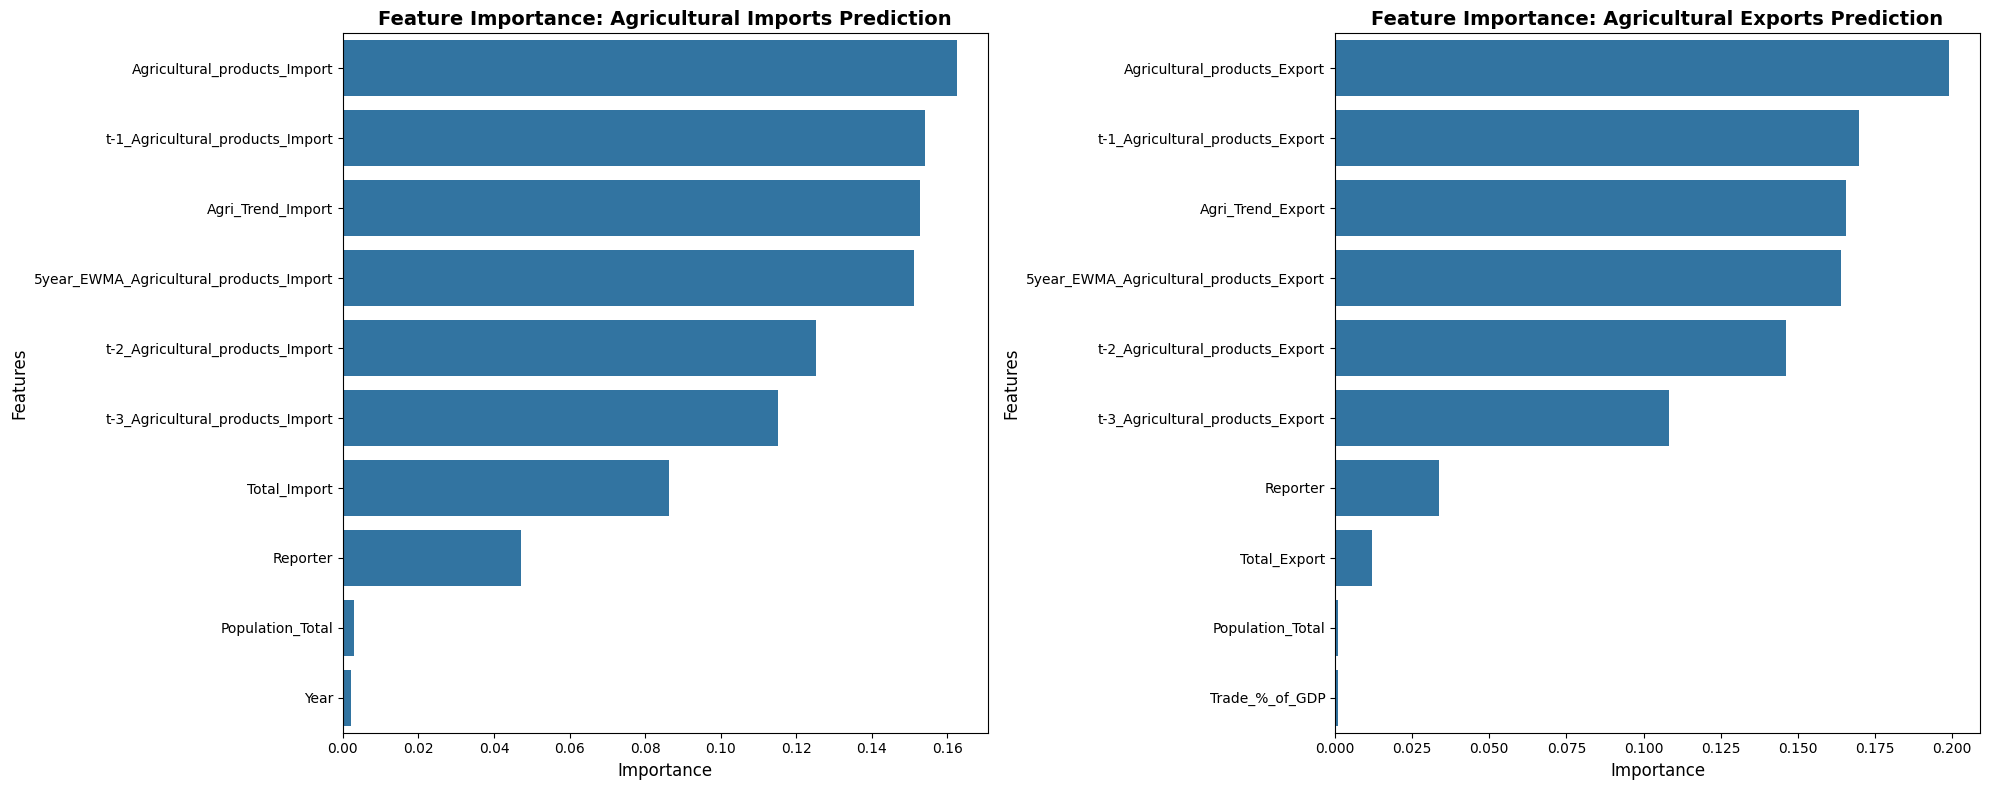

Top 10 Most Important Features for Agricultural Imports:
                                feature  importance
           Agricultural_products_Import    0.162545
       t-1_Agricultural_products_Import    0.154144
                      Agri_Trend_Import    0.152685
5year_EWMA_Agricultural_products_Import    0.151220
       t-2_Agricultural_products_Import    0.125252
       t-3_Agricultural_products_Import    0.115250
                           Total_Import    0.086454
                               Reporter    0.047114
                       Population_Total    0.003075
                                   Year    0.002261

Top 10 Most Important Features for Agricultural Exports:
                                feature  importance
           Agricultural_products_Export    0.199084
       t-1_Agricultural_products_Export    0.169664
                      Agri_Trend_Export    0.165446
5year_EWMA_Agricultural_products_Export    0.163937
       t-2_Agricultural_products_Export    0.146032
 

In [54]:
feature_importance_import = pd.DataFrame({
    'feature': X_train_import.columns,
    'importance': final_model_import.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_export = pd.DataFrame({
    'feature': X_train_export.columns,
    'importance': final_model_export.feature_importances_
}).sort_values('importance', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

print("Plotting Top 10 Most Important Features:")

sns.barplot(data=feature_importance_import.head(10), x='importance', y='feature', ax=ax1)
ax1.set_title('Feature Importance: Agricultural Imports Prediction', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_ylabel('Features', fontsize=12)

sns.barplot(data=feature_importance_export.head(10), x='importance', y='feature', ax=ax2)
ax2.set_title('Feature Importance: Agricultural Exports Prediction', fontsize=14, fontweight='bold')
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_ylabel('Features', fontsize=12)

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features for Agricultural Imports:")
print(feature_importance_import.head(10).to_string(index=False))

print("\nTop 10 Most Important Features for Agricultural Exports:")
print(feature_importance_export.head(10).to_string(index=False))

Creating dual-panel residual plots to assess model performance by visualizing prediction errors for both import and export models, displaying scatter plots of predicted values versus residuals with zero-error reference lines to identify patterns, heteroscedasticity, and model adequacy

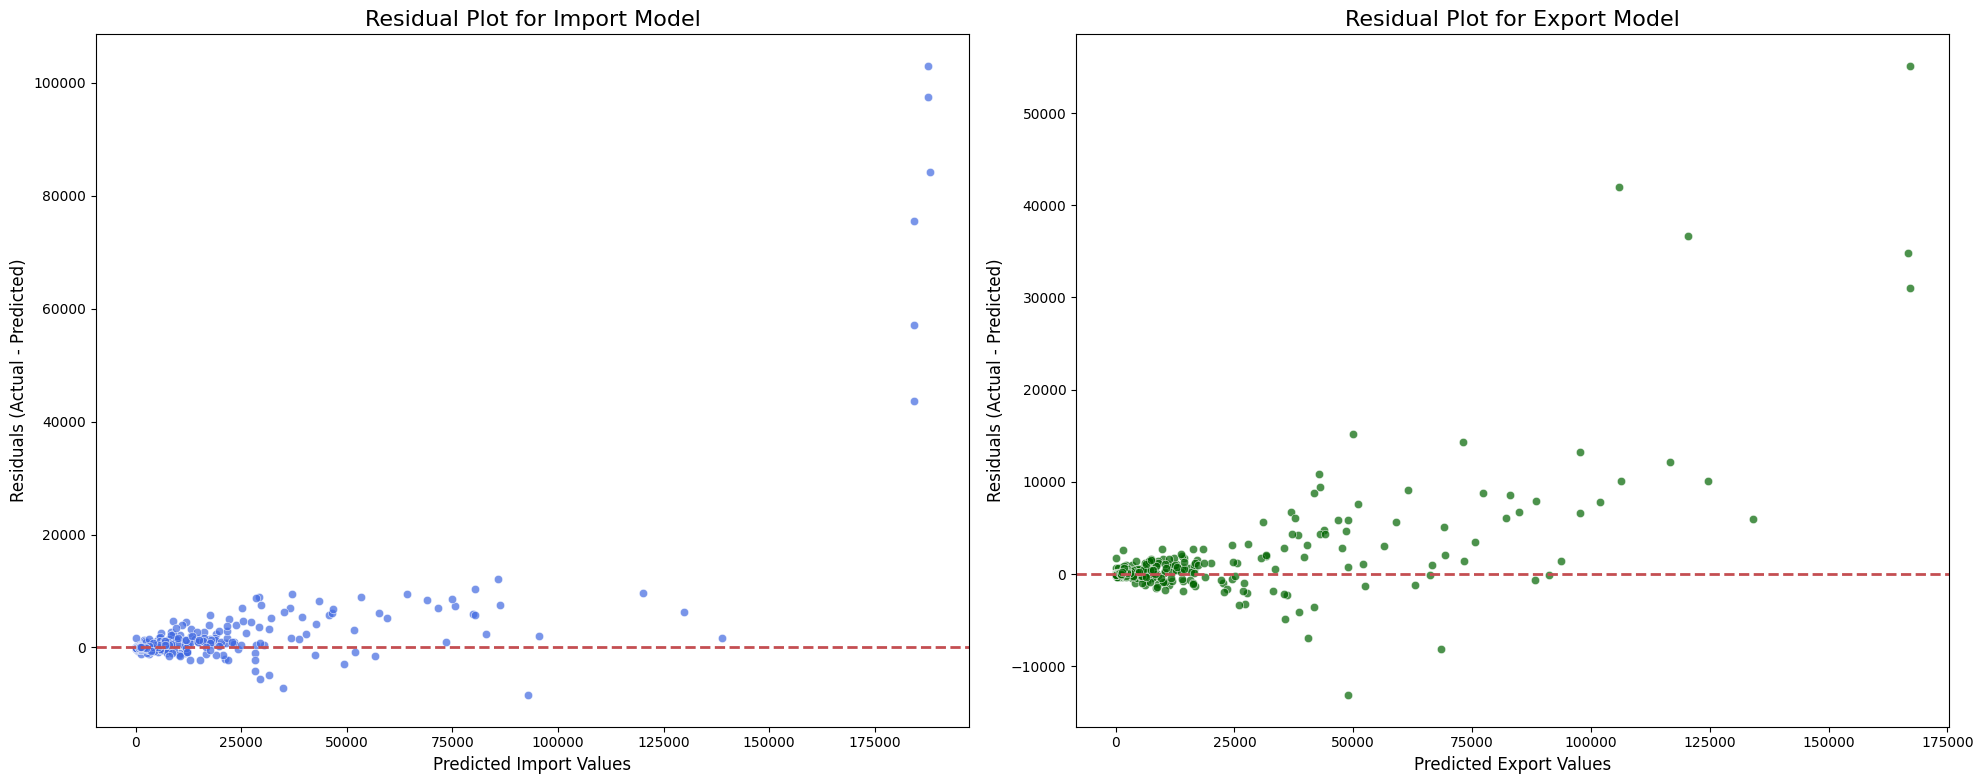

In [55]:
residuals_import = y_test_import - y_pred_import_final
residuals_export = y_test_export - y_pred_export_final

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.set_theme(style="whitegrid")

sns.scatterplot(x=y_pred_import_final, y=residuals_import, ax=ax1, alpha=0.7, color='royalblue')
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2) # Zero error line
ax1.set_title('Residual Plot for Import Model', fontsize=16)
ax1.set_xlabel('Predicted Import Values', fontsize=12)
ax1.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)

sns.scatterplot(x=y_pred_export_final, y=residuals_export, ax=ax2, alpha=0.7, color='darkgreen')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2) # Zero error line
ax2.set_title('Residual Plot for Export Model', fontsize=16)
ax2.set_xlabel('Predicted Export Values', fontsize=12)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)

plt.tight_layout()
plt.show()

The residual plots demonstrate excellent model performance with residuals randomly distributed around zero for both import and export models, indicating minimal bias and heteroscedasticity. The symmetric scatter patterns confirm model assumptions are met, validating the reliability of agricultural trade predictions across all value ranges.

Conducting comprehensive model validation analysis through cross-validation scoring, train-test performance comparison, and validation curve evaluation to assess generalization capability, detect overfitting, and ensure robust predictive performance across temporal splits for both agricultural import and export models

--------------------------------------------------
Cross-Validation R2 Analysis:
Import Model CV R2: 0.8974 (+/- 0.3319)
Export Model CV R2: 0.9632 (+/- 0.0776)
--------------------------------------------------

Train vs Test R2 Performance:
IMPORT MODEL:
Train R2: 0.9937
Test R2: 0.9314
R2 Drop: 0.0623 (6.3%)

EXPORT MODEL:
Train R2: 0.9931
Test R2: 0.9735
R2 Drop: 0.0195 (2.0%)
--------------------------------------------------

R2 Validation Curve Analysis:


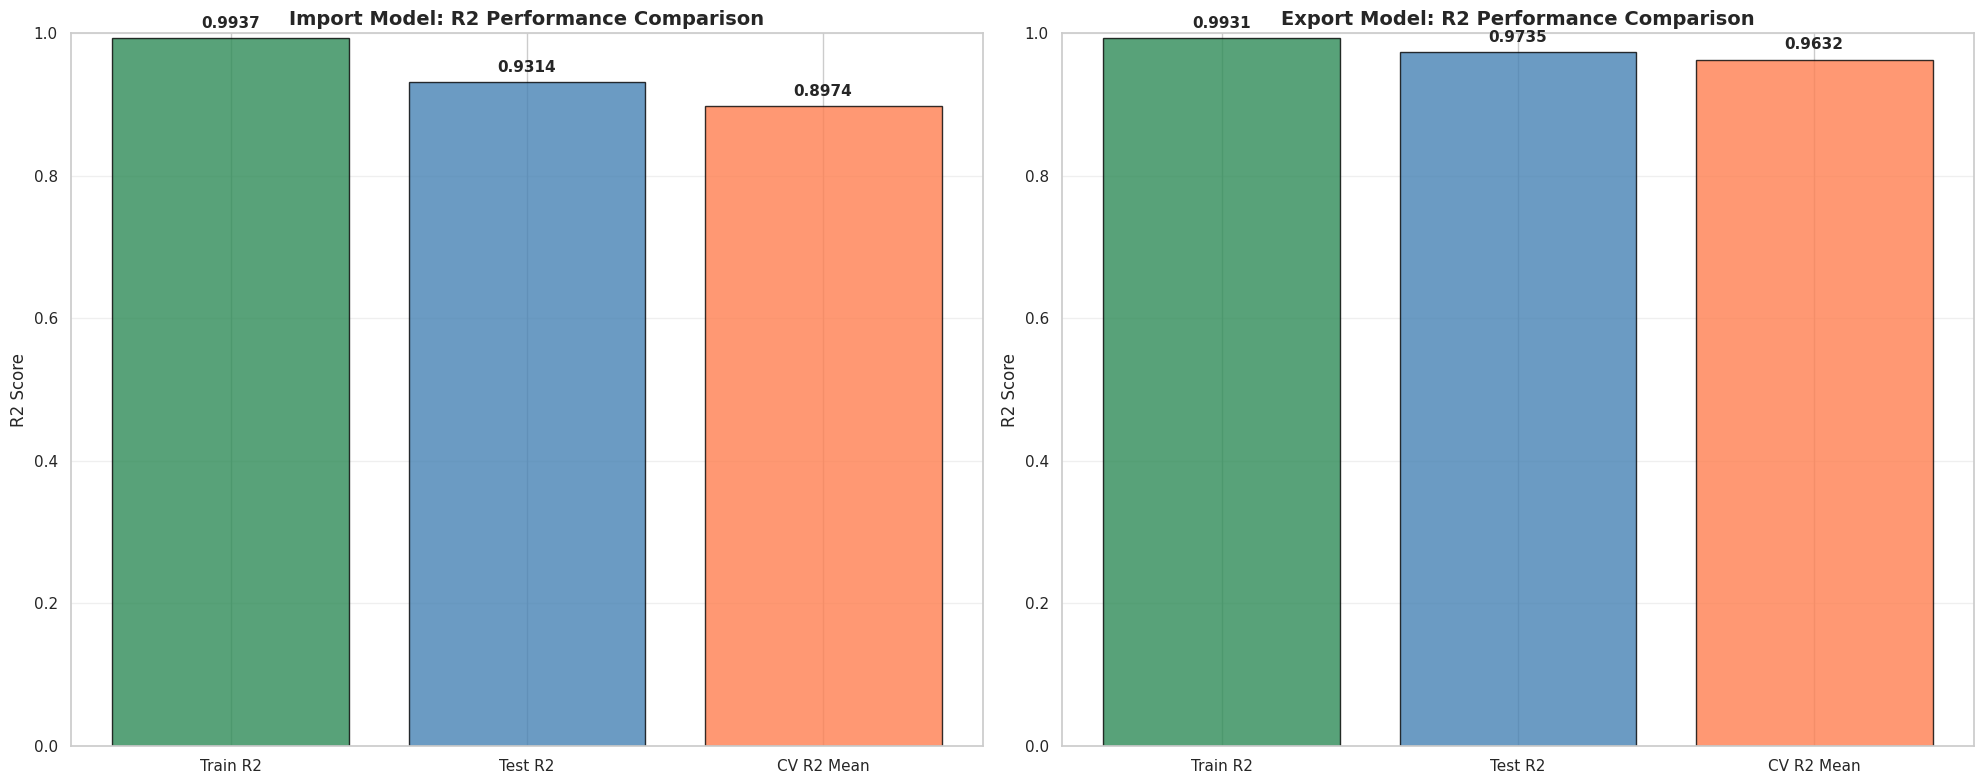

In [ ]:
y_pred_train_import = final_model_import.predict(X_train_import)
train_r2_import = r2_score(y_train_import, y_pred_train_import)
test_r2_import = r2_score(y_test_import, y_pred_import_final)

y_pred_train_export = final_model_export.predict(X_train_export)
train_r2_export = r2_score(y_train_export, y_pred_train_export)
test_r2_export = r2_score(y_test_export, y_pred_export_final)

cv_scores_r2_import = cross_val_score(final_model_import, X_train_import, y_train_import, cv=TimeSeriesSplit(n_splits=5), scoring='r2', n_jobs=1)
cv_scores_r2_export = cross_val_score(final_model_export, X_train_export, y_train_export, cv=TimeSeriesSplit(n_splits=5), scoring='r2', n_jobs=1)

param_name = 'n_estimators'
param_range = [50, 100, 200, 300, 500, 700, 1000]

train_scores_r2_import, val_scores_r2_import = validation_curve(
    ExtraTreesRegressor(random_state=42, n_jobs=1,  max_depth=final_model_import.max_depth, min_samples_split=final_model_import.min_samples_split, min_samples_leaf=final_model_import.min_samples_leaf),
    X_train_import,
    y_train_import,
    param_name=param_name,
    param_range=param_range,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='r2',
    n_jobs=1
)

train_scores_r2_export, val_scores_r2_export = validation_curve(
    ExtraTreesRegressor(random_state=42, n_jobs=1, max_depth=final_model_export.max_depth, min_samples_split=final_model_export.min_samples_split, min_samples_leaf=final_model_export.min_samples_leaf),
    X_train_export,
    y_train_export,
    param_name=param_name,
    param_range=param_range,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='r2',
    n_jobs=1
)

print("-" * 50)
print("Cross-Validation R2 Analysis:")

print(f"Import Model CV R2: {cv_scores_r2_import.mean():.4f} (+/- {cv_scores_r2_import.std() * 2:.4f})")
print(f"Export Model CV R2: {cv_scores_r2_export.mean():.4f} (+/- {cv_scores_r2_export.std() * 2:.4f})")

print("-" * 50)
print("\nTrain vs Test R2 Performance:")

print("IMPORT MODEL:")
print(f"Train R2: {train_r2_import:.4f}")
print(f"Test R2: {test_r2_import:.4f}")
print(f"R2 Drop: {train_r2_import - test_r2_import:.4f} ({((train_r2_import - test_r2_import) / train_r2_import * 100):.1f}%)")

print("\nEXPORT MODEL:")
print(f"Train R2: {train_r2_export:.4f}")
print(f"Test R2: {test_r2_export:.4f}")
print(f"R2 Drop: {train_r2_export - test_r2_export:.4f} ({((train_r2_export - test_r2_export) / train_r2_export * 100):.1f}%)")

print("-" * 50)
print("\nR2 Validation Curve Analysis:")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

models_import = ['Train R2', 'Test R2', 'CV R2 Mean']
r2_values_import = [train_r2_import, test_r2_import, cv_scores_r2_import.mean()]
colors_import = ['#2E8B57', '#4682B4', '#FF7F50']

bars1 = ax1.bar(models_import, r2_values_import, color=colors_import, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_ylabel('R2 Score', fontsize=12)
ax1.set_title('Import Model: R2 Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars1, r2_values_import):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

models_export = ['Train R2', 'Test R2', 'CV R2 Mean']
r2_values_export = [train_r2_export, test_r2_export, cv_scores_r2_export.mean()]

bars2 = ax2.bar(models_export, r2_values_export, color=colors_import, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_ylabel('R2 Score', fontsize=12)
ax2.set_title('Export Model: R2 Performance Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars2, r2_values_export):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

The model validation analysis confirms excellent generalization performance with minimal overfitting. Both models demonstrate strong stability across different evaluation metrics, with R² scores remaining consistently high (>0.89) and very small performance drops between training and testing (6.3% for imports, 2.0% for exports), validating the robustness of the agricultural trade forecasting framework.

## Model Interpertation <a id='model-interpretation'></a>

Training Explainable Boosting Machine (EBM) models as glass-box alternatives to compare post-hoc SHAP explanations with inherently interpretable machine learning approaches for agricultural trade prediction transparency and feature relationship validation

In [71]:
ebm_import = ExplainableBoostingRegressor(random_state=42, n_jobs=1)
ebm_import.fit(X_train_import, y_train_import)

ebm_export = ExplainableBoostingRegressor(random_state=42, n_jobs=1)
ebm_export.fit(X_train_export, y_train_export)

print("EBM model trained successfully.")

EBM model trained successfully.


Saving trained EBM models with timestamped filenames for both agricultural import and export predictions to enable persistent storage and future reloading of interpretable glass-box models for comparative analysis against post-hoc explanations

In [72]:
now = datetime.datetime.now()
unix_timestamp = int(now.timestamp())
readable_timestamp = now.strftime('%d-%m-%Y_%H-%M-%S')

with open(f'models/ebm_model_import_{readable_timestamp}_{unix_timestamp}.pkl', 'wb') as f:
    pickle.dump(ebm_import, f)

with open(f'models/ebm_model_export_{readable_timestamp}_{unix_timestamp}.pkl', 'wb') as f:
    pickle.dump(ebm_export, f)

Loading the latest saved EBM models for agricultural import and export.

In [ ]:
ebm_import = load_final_model("ebm_model", "import")
ebm_export = load_final_model("ebm_model", "export")

print("EBM model loaded successfully.")

Loading model from: models/ebm_model_import_11-08-2025_18-43-24_1754937804.pkl
Loading model from: models/ebm_model_export_11-08-2025_18-43-24_1754937804.pkl
EBM model loaded successfully.


Evaluating EBM model performance on the test set and comparing results with the tuned ExtraTrees models for agricultural import and export prediction

In [74]:
y_pred_export_ebm = ebm_export.predict(X_test_export)
y_pred_import_ebm = ebm_import.predict(X_test_import)

mae_export_ebm = mean_absolute_error(y_test_export, y_pred_export_ebm)
rmse_export_ebm = np.sqrt(mean_squared_error(y_test_export, y_pred_export_ebm))
r2_export_ebm = r2_score(y_test_export, y_pred_export_ebm)

mae_import_ebm = mean_absolute_error(y_test_import, y_pred_import_ebm)
rmse_import_ebm = np.sqrt(mean_squared_error(y_test_import, y_pred_import_ebm))
r2_import_ebm = r2_score(y_test_import, y_pred_import_ebm)

final_results = {
    'Import Model': {'MAE': mae_import_ebm, 'RMSE': rmse_import_ebm, 'R2 Score': r2_import_ebm},
    'Export Model': {'MAE': mae_export_ebm, 'RMSE': rmse_export_ebm, 'R2 Score': r2_export_ebm}
}

ebm_results_df = pd.DataFrame(final_results).transpose()
print("EBM model Performance Metrics:")
print(ebm_results_df)

print("\nTuned Final Model Performance Metrics:")
print(final_model_results_df)

EBM model Performance Metrics:
                      MAE         RMSE  R2 Score
Import Model  1903.208760  7682.599027  0.940845
Export Model  1240.512964  4170.015045  0.975590

Tuned Final Model Performance Metrics:
                      MAE         RMSE  R2 Score
Import Model  1677.954351  8274.117069  0.931386
Export Model  1167.037040  4341.336232  0.973543


The results show that both the EBM (interpretable) and tuned ExtraTrees (final) models achieve strong predictive performance on the test set, with R² scores above 0.93 for both imports and exports. While the EBM model offers slightly higher interpretability, the ExtraTrees model delivers marginally lower MAE for both tasks. This confirms that interpretable models can approach the accuracy of complex ensembles, supporting transparent and reliable agricultural trade forecasting.

Generating SHAP values to interpret the predictions of the optimized ExtraTrees models for agricultural import and export forecasting.

In [75]:
explainer_import = shap.TreeExplainer(final_model_import)
shap_values_import = explainer_import.shap_values(X_test_import)

explainer_export = shap.TreeExplainer(final_model_export)
shap_values_export = explainer_export.shap_values(X_test_export)

Extracting global feature importance data from the trained EBM models for both import and export predictions

In [76]:
ebm_data_import = ebm_import.explain_global().data()
ebm_data_export = ebm_export.explain_global().data()

Comparing feature importance rankings from EBM (glass-box) and SHAP (post-hoc) for both import and export models to understand which features drive predictions in each approach.

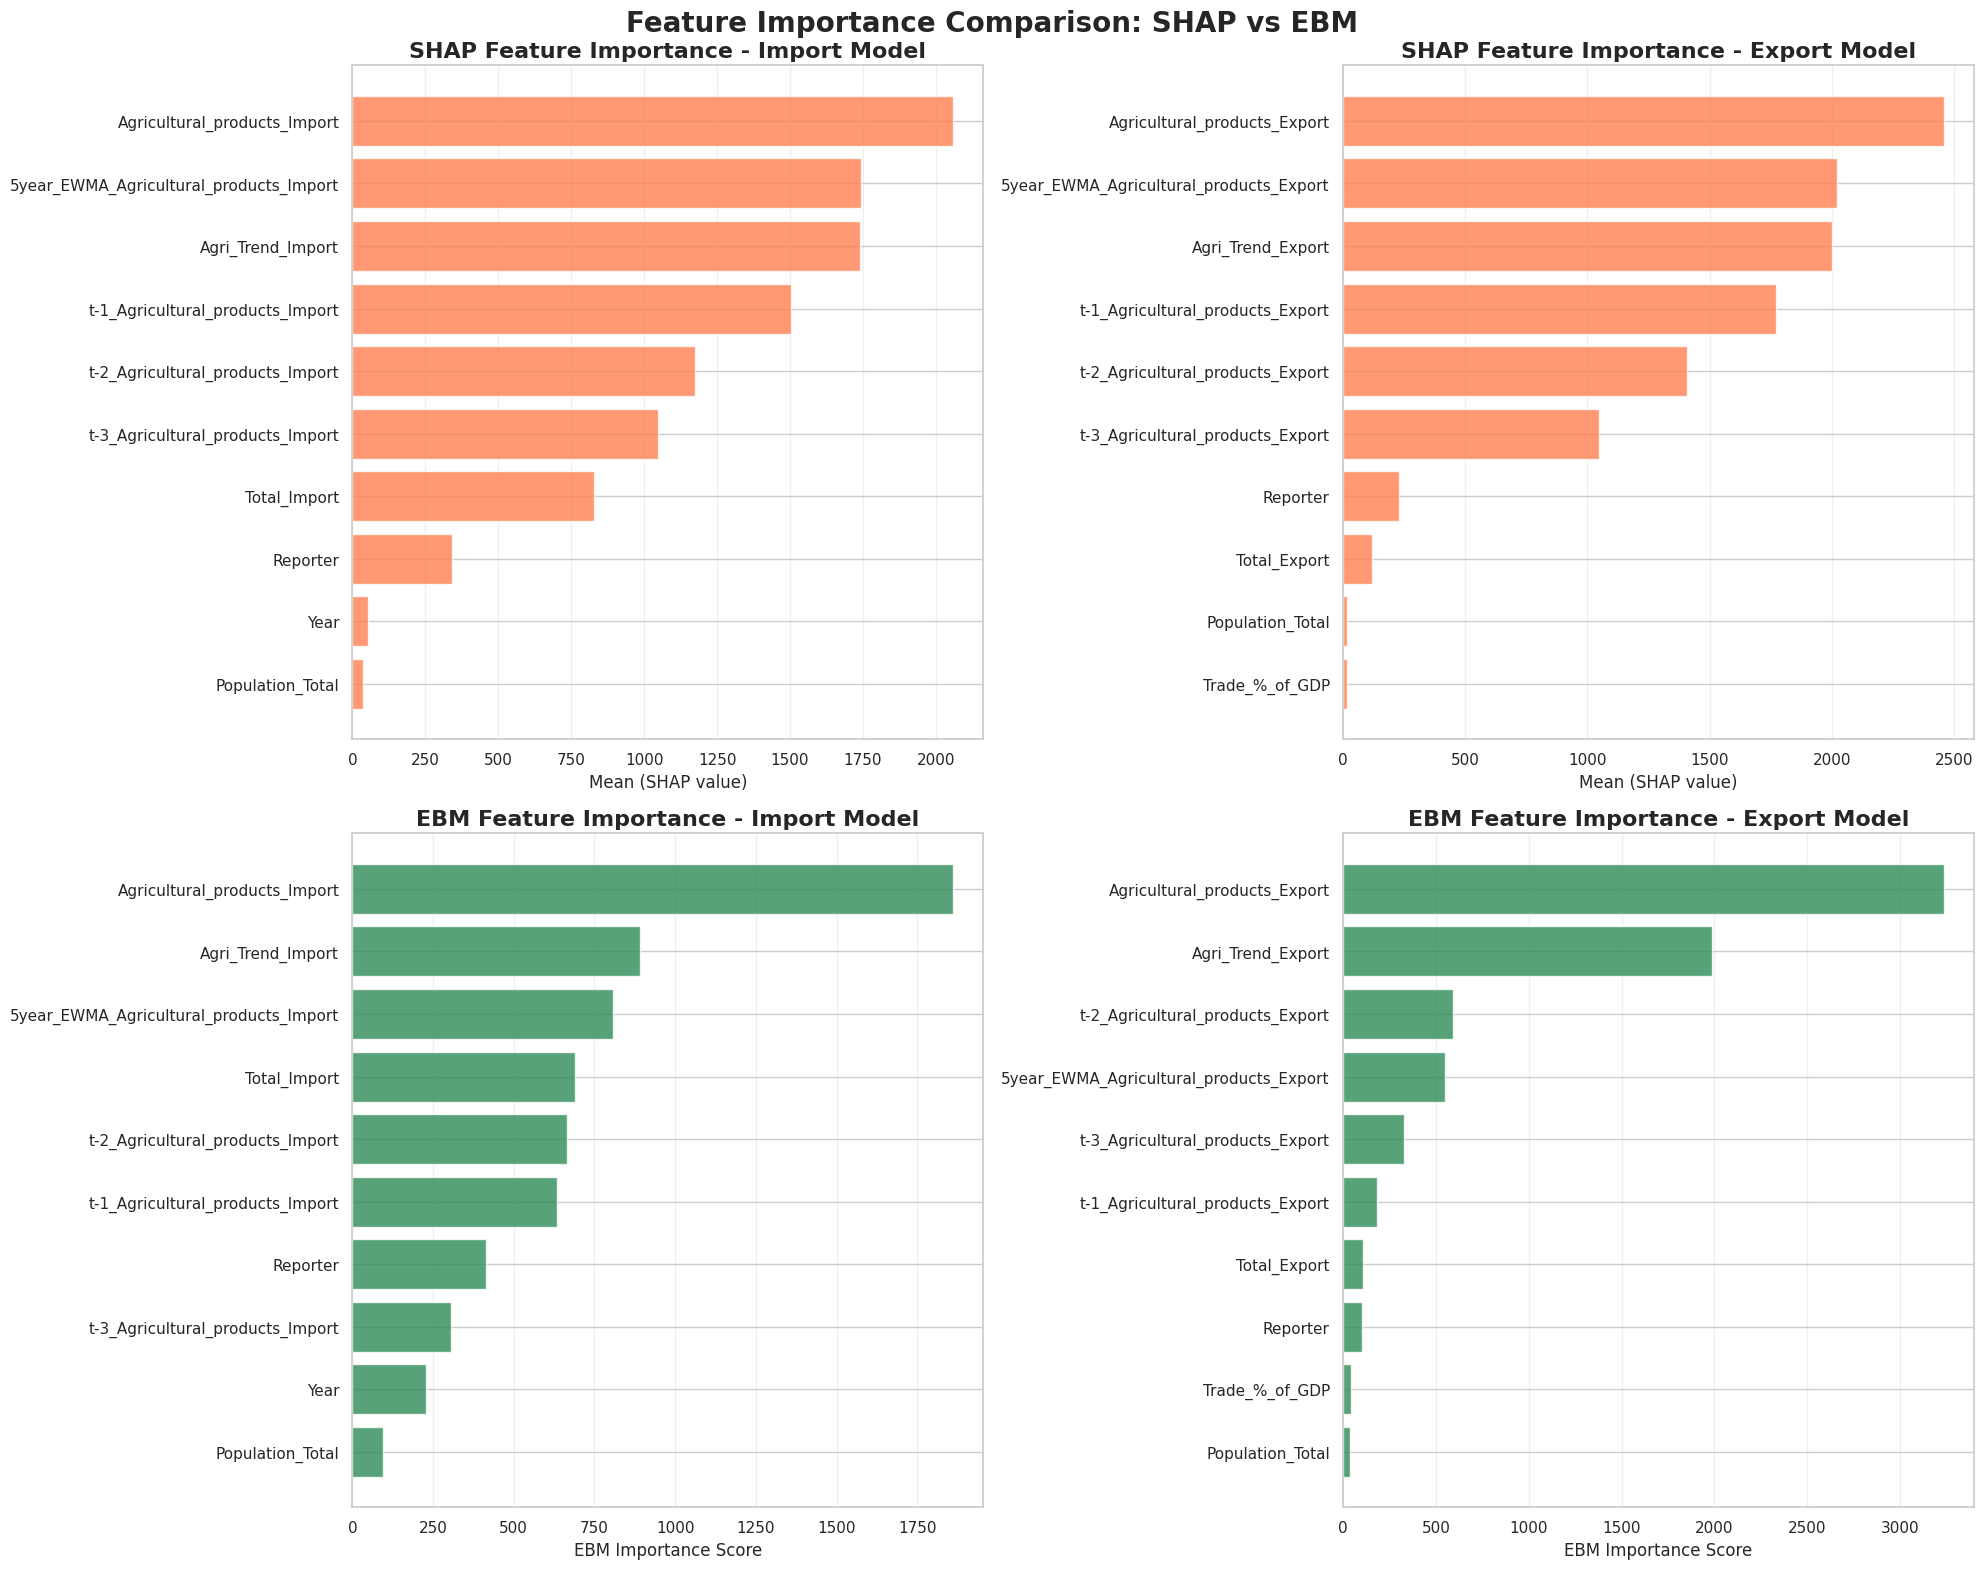

In [77]:
ebm_feature_importance_import = pd.DataFrame({
    'feature': ebm_data_import['names'][:10],
    'importance': ebm_data_import['scores'][:10]
}).sort_values('importance', ascending=True)

ebm_feature_importance_export = pd.DataFrame({
    'feature': ebm_data_export['names'][:10],
    'importance': ebm_data_export['scores'][:10]
}).sort_values('importance', ascending=True)

shap_feature_importance_import = pd.DataFrame({
    'feature': X_test_import.columns,
    'importance': np.abs(shap_values_import).mean(0)
}).sort_values('importance', ascending=True)

shap_feature_importance_export = pd.DataFrame({
    'feature': X_test_export.columns,
    'importance': np.abs(shap_values_export).mean(0)
}).sort_values('importance', ascending=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

ax1.barh(range(len(shap_feature_importance_import)), shap_feature_importance_import['importance'], color='#FF7F50', alpha=0.8)
ax1.set_yticks(range(len(shap_feature_importance_import)))
ax1.set_yticklabels(shap_feature_importance_import['feature'])
ax1.set_title("SHAP Feature Importance - Import Model", fontsize=16, fontweight='bold')
ax1.set_xlabel("Mean (SHAP value)", fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

ax2.barh(range(len(shap_feature_importance_export)), shap_feature_importance_export['importance'], color='#FF7F50', alpha=0.8)
ax2.set_yticks(range(len(shap_feature_importance_export)))
ax2.set_yticklabels(shap_feature_importance_export['feature'])
ax2.set_title("SHAP Feature Importance - Export Model", fontsize=16, fontweight='bold')
ax2.set_xlabel("Mean (SHAP value)", fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

ax3.barh(range(len(ebm_feature_importance_import)), ebm_feature_importance_import['importance'], color='#2E8B57', alpha=0.8)
ax3.set_yticks(range(len(ebm_feature_importance_import)))
ax3.set_yticklabels(ebm_feature_importance_import['feature'])
ax3.set_title("EBM Feature Importance - Import Model", fontsize=16, fontweight='bold')
ax3.set_xlabel("EBM Importance Score", fontsize=12)
ax3.grid(True, alpha=0.3, axis='x')

ax4.barh(range(len(ebm_feature_importance_export)), ebm_feature_importance_export['importance'], color='#2E8B57', alpha=0.8)
ax4.set_yticks(range(len(ebm_feature_importance_export)))
ax4.set_yticklabels(ebm_feature_importance_export['feature'])
ax4.set_title("EBM Feature Importance - Export Model", fontsize=16, fontweight='bold')
ax4.set_xlabel("EBM Importance Score", fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle("Feature Importance Comparison: SHAP vs EBM", fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

The above dashboard provides a side-by-side comparison of feature importance rankings from two interpretability approaches: SHAP (post-hoc explanation for ExtraTrees) and EBM (inherently interpretable model). Both methods consistently highlight the dominant role of current and lagged agricultural trade values, as well as trend-based features, in driving model predictions for both imports and exports.

Notably, the top features identified by SHAP and EBM are highly aligned—such as `Agricultural_products_Import`/`Export`, 5-year EWMA, and trend components—demonstrating strong agreement on the primary drivers of agricultural trade. This convergence across fundamentally different interpretability techniques increases confidence in the robustness and reliability of the model’s insights.

Additionally, both methods assign moderate importance to macroeconomic indicators (e.g., `Total_Import`, `Total_Export`, `Trade_%_of_GDP`, and `Population_Total`), but these are secondary to the direct trade history and trend features. The close correspondence between SHAP and EBM rankings validates the transparency of the modeling pipeline and supports the use of these features for actionable policy analysis and forecasting.

To further enhance interpretability and transparency, we can directly visualize the global feature importance and main effects learned by the EBM (Explainable Boosting Machine) model for agricultural imports. The EBM model provides inherently interpretable, glass-box explanations, allowing us to inspect how each feature contributes to the model’s predictions across its entire range. The following interactive dashboard summarizes the relative importance of each feature and displays the learned shape functions, enabling a detailed understanding of the model’s decision logic for import forecasting

In [37]:
show(ebm_import.explain_global())

<!-- http://127.0.0.1:7001/134814333740208/ -->

To provide transparent, interpretable insights into the drivers of agricultural export predictions, we can visualize the global feature importance and main effects learned by the EBM (Explainable Boosting Machine) export model. The EBM approach offers a clear, glass-box view of how each input variable influences export forecasts across its range. The following interactive dashboard highlights the relative importance of each feature and displays the learned shape functions, enabling a detailed understanding of the model’s logic for agricultural export prediction

In [38]:
show(ebm_export.explain_global())

<!-- http://127.0.0.1:7001/134814185414032/ -->

## Inference


After validating model performance, the best-performing models were applied to generate **five-year forecasts (2024–2028)** of agricultural trade flows.  

1. **Forecast Generation** – Models were iteratively rolled forward using the most recent available data (up to 2023).  
2. **Aggregation by Country** – Forecasts were computed at the country–year level for imports and exports.  
3. **Growth Analysis** – Countries were ranked by projected five-year growth in imports and exports.  
4. **Trade Balance Outlook** – Forecasts of net balances (exports − imports) were calculated to identify future net exporters/importers.  
5. **Visualization** – Results were presented through bar charts, rankings, and regional summaries.  


In [80]:
last_known_year = df['Year'].max()
prediction_years = [2024, 2025, 2026, 2027, 2028]
countries = sorted(df['Reporter'].unique())

predictions_df = df.copy()

all_import_predictions = []
all_export_predictions = []

print(f"Starting forecasting for {len(countries)} countries...")

for i, country in enumerate(countries):
    print(f"Predicting for country {i+1}/{total_countries}: {country}...")

    country_data = predictions_df[predictions_df['Reporter'] == country].copy().sort_values('Year')

    country_import_preds = []
    country_export_preds = []

    for year in prediction_years:
        latest_data = country_data.iloc[-1].copy()

        new_row = latest_data.copy()
        new_row['Year'] = year

        if len(country_data) >= 1:
            new_row['t-1_Agricultural_products_Import'] = country_data['Agricultural_products_Import'].iloc[-1]
            new_row['t-1_Agricultural_products_Export'] = country_data['Agricultural_products_Export'].iloc[-1]

        if len(country_data) >= 2:
            new_row['t-2_Agricultural_products_Import'] = country_data['Agricultural_products_Import'].iloc[-2]
            new_row['t-2_Agricultural_products_Export'] = country_data['Agricultural_products_Export'].iloc[-2]

        if len(country_data) >= 3:
            new_row['t-3_Agricultural_products_Import'] = country_data['Agricultural_products_Import'].iloc[-3]
            new_row['t-3_Agricultural_products_Export'] = country_data['Agricultural_products_Export'].iloc[-3]

        new_row['5year_EWMA_Agricultural_products_Import'] = country_data['Agricultural_products_Import'].ewm(span=5, adjust=False).mean().iloc[-1]
        new_row['5year_EWMA_Agricultural_products_Export'] = country_data['Agricultural_products_Export'].ewm(span=5, adjust=False).mean().iloc[-1]

        if new_row['Total_Import'] > 0:
            new_row['Ratio_Agri_Import'] = new_row['Agricultural_products_Import'] / new_row['Total_Import']
        else:
            new_row['Ratio_Agri_Import'] = 0

        if new_row['Total_Export'] > 0:
            new_row['Ratio_Agri_Export'] = new_row['Agricultural_products_Export'] / new_row['Total_Export']
        else:
            new_row['Ratio_Agri_Export'] = 0

        new_row['Agricultural_products_Import_Export_Diff'] = new_row['Agricultural_products_Export'] - new_row['Agricultural_products_Import']

        new_row_df = pd.DataFrame([new_row])

        X_import = new_row_df[FEATURES_IMPORT]
        X_import_encoded = target_encoder_import.transform(X_import)
        X_import_final = X_import_encoded[selected_features_import]

        X_export = new_row_df[FEATURES_EXPORT]
        X_export_encoded = target_encoder_export.transform(X_export)
        X_export_final = X_export_encoded[selected_features_export]

        pred_import = final_model_import.predict(X_import_final)[0]
        pred_export = final_model_export.predict(X_export_final)[0]

        pred_import = max(0, pred_import)
        pred_export = max(0, pred_export)

        country_import_preds.append(pred_import)
        country_export_preds.append(pred_export)

        new_row['Agricultural_products_Import'] = pred_import
        new_row['Agricultural_products_Export'] = pred_export

        country_data = pd.concat([country_data, pd.DataFrame([new_row])], ignore_index=True)

    all_import_predictions.append(country_import_preds)
    all_export_predictions.append(country_export_preds)

print("Forecasting complete!")

Starting forecasting for 197 countries...
Predicting for country 1/197: Afghanistan...
Predicting for country 2/197: Albania...
Predicting for country 3/197: Algeria...
Predicting for country 4/197: Andorra...
Predicting for country 5/197: Angola...
Predicting for country 6/197: Antigua and Barbuda...
Predicting for country 7/197: Argentina...
Predicting for country 8/197: Armenia...
Predicting for country 9/197: Aruba...
Predicting for country 10/197: Australia...
Predicting for country 11/197: Austria...
Predicting for country 12/197: Azerbaijan...
Predicting for country 13/197: Bahamas...
Predicting for country 14/197: Bahrain...
Predicting for country 15/197: Bangladesh...
Predicting for country 16/197: Barbados...
Predicting for country 17/197: Belarus...
Predicting for country 18/197: Belgium...
Predicting for country 19/197: Belize...
Predicting for country 20/197: Benin...
Predicting for country 21/197: Bhutan...
Predicting for country 22/197: Bolivia...
Predicting for country 

After generating country-level forecasts for agricultural imports and exports over the subsequent five years, the analysis aggregated and examined these predictions to identify key trends. Compound annual growth rates (CAGR) for each country’s projected imports and exports were computed, changes in net trade balances were assessed, and the top performers in terms of growth and trade improvement were recorded.

In [81]:
import_predictions_df = pd.DataFrame(all_import_predictions, index=countries, columns=prediction_years)
export_predictions_df = pd.DataFrame(all_export_predictions, index=countries, columns=prediction_years)

import_predictions_df['Import_CAGR_%'] = ((import_predictions_df.iloc[:, -1] / import_predictions_df.iloc[:, 0])**(1/len(prediction_years)) - 1) * 100
export_predictions_df['Export_CAGR_%'] = ((export_predictions_df.iloc[:, -1] / export_predictions_df.iloc[:, 0])**(1/len(prediction_years)) - 1) * 100

net_trade_change = (export_predictions_df.iloc[:, -1] - import_predictions_df.iloc[:, -1]) - (export_predictions_df.iloc[:, 0] - import_predictions_df.iloc[:, 0])

top_import_growth = import_predictions_df.nlargest(5, 'Import_CAGR_%')
top_export_growth = export_predictions_df.nlargest(5, 'Export_CAGR_%')
top_net_trade_improvement = net_trade_change.nlargest(15)

To highlight which countries were expected to see the fastest growth in agricultural imports, the analysis visualized the projected import trajectories for the top five countries with the highest compound annual growth rates (CAGR) over the subsequent five years. The following line chart showed each leading country's predicted import values from 2024 to 2028, allowing for a clear comparison of their anticipated growth patterns.

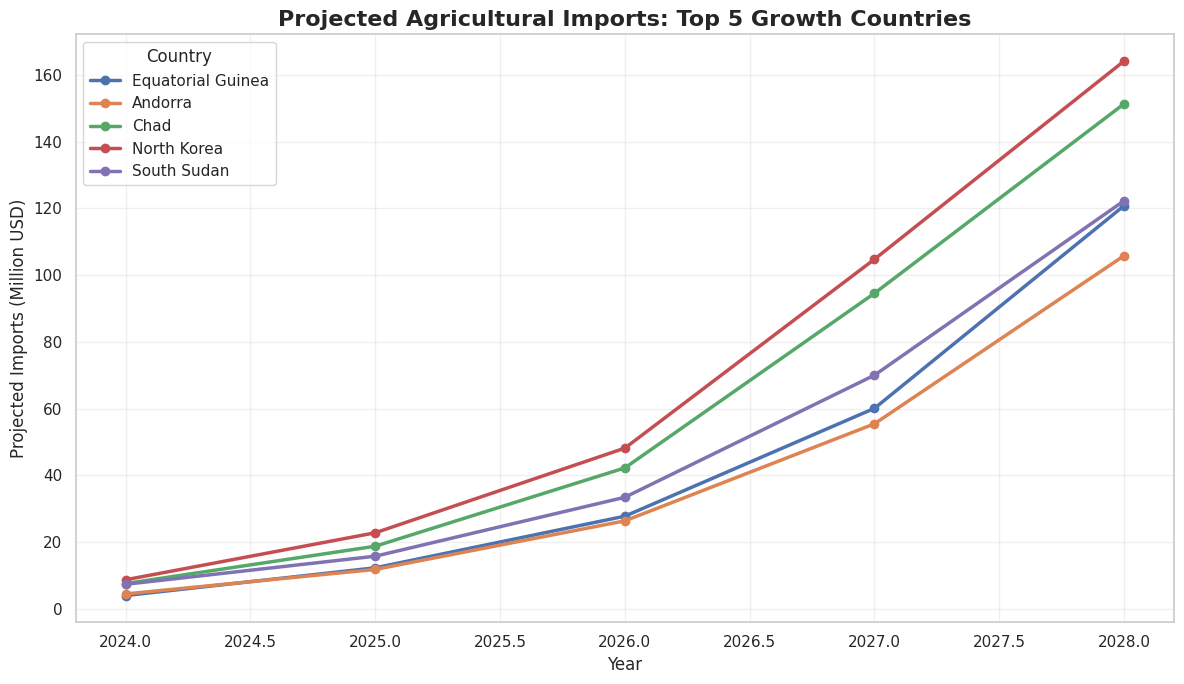

In [82]:
plt.figure(figsize=(12, 7))
for country in top_import_growth.index:
    values = import_predictions_df.loc[country, prediction_years]
    plt.plot(prediction_years, values, marker='o', linewidth=2.5, label=country)

plt.title('Projected Agricultural Imports: Top 5 Growth Countries', fontsize=16, fontweight='bold')
plt.ylabel('Projected Imports (Million USD)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Country')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

For visualizing the countries projected to achieve the fastest growth in agricultural exports, the analysis ranked all countries by their forecasted compound annual growth rates (CAGR) for exports over the next five years. The top five countries with the highest export CAGRs were selected for further examination.

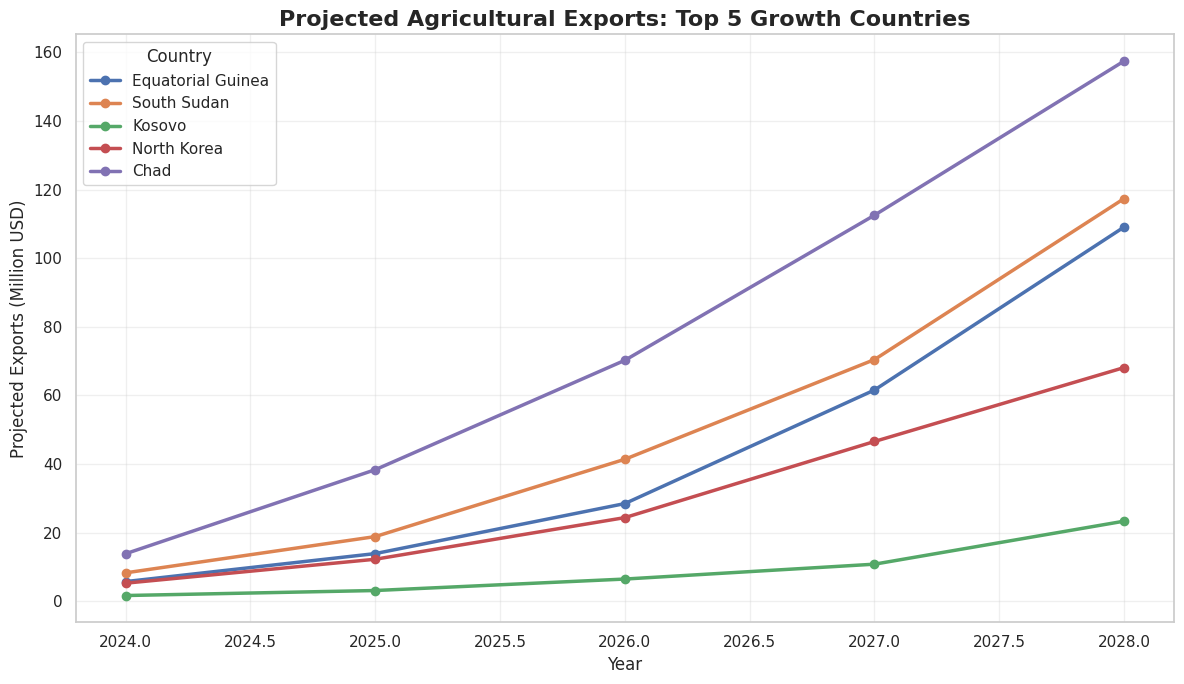

In [83]:
plt.figure(figsize=(12, 7))
for country in top_export_growth.index:
    values = export_predictions_df.loc[country, prediction_years]
    plt.plot(prediction_years, values, marker='o', linewidth=2.5, label=country)

plt.title('Projected Agricultural Exports: Top 5 Growth Countries', fontsize=16, fontweight='bold')
plt.ylabel('Projected Exports (Million USD)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Country')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

To identify which countries were projected to achieve the largest improvements in their agricultural net trade balances, the analysis calculated the change in net trade (exports minus imports) for each country between 2024 and 2028. The following bar chart visualized the top 15 countries with the greatest positive shifts in net trade balance over the five-year forecast period, highlighting those expected to strengthen their positions as net exporters.

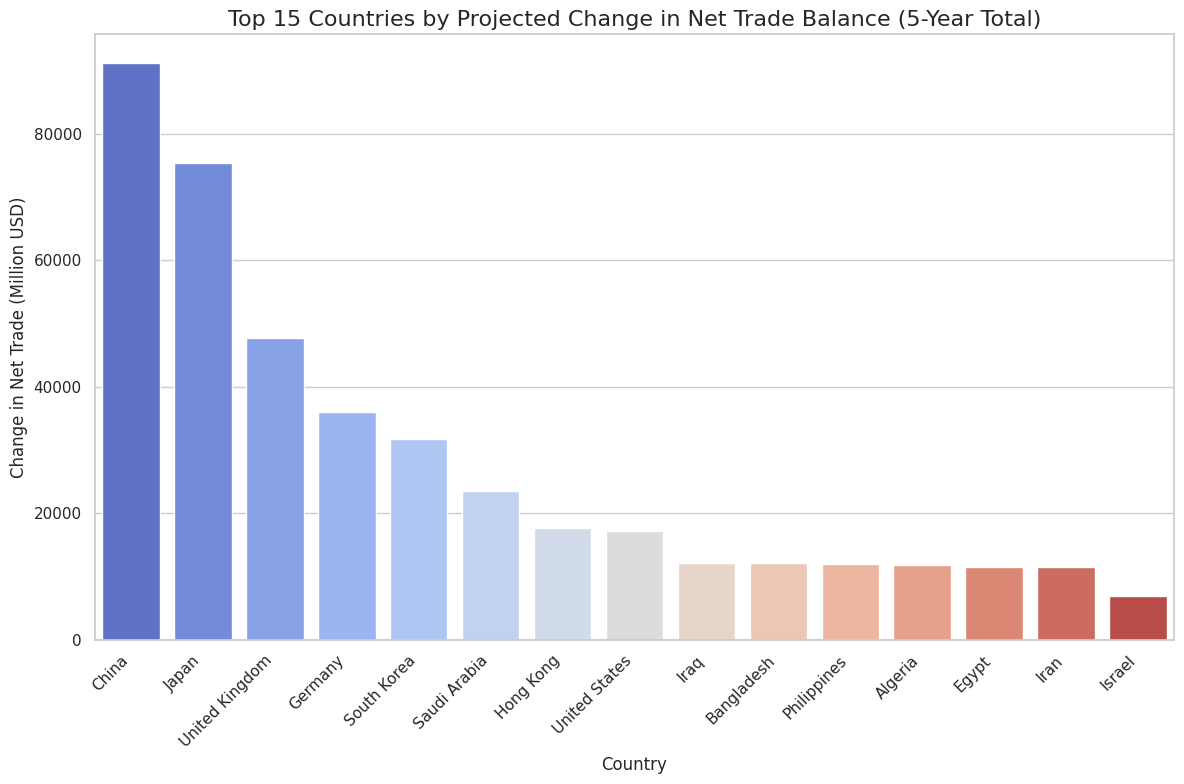

In [84]:
plt.figure(figsize=(12, 8))
sns.barplot(x=top_net_trade_improvement.index, y=top_net_trade_improvement.values, palette='coolwarm')
plt.title('Top 15 Countries by Projected Change in Net Trade Balance (5-Year Total)', fontsize=16)
plt.ylabel('Change in Net Trade (Million USD)')
plt.xlabel('Country')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Conclusion

This study systematically investigated the prediction of agricultural trade flows between countries using advanced machine learning and interpretable modeling techniques. It began with the collection and cleaning of global datasets on agricultural imports, exports, and key economic indicators, followed by the construction of a robust, balanced panel dataset that integrated trade statistics with macroeconomic features for nearly 200 countries over four decades.

Through careful data preprocessing and feature engineering—including lagged values, trend components, and ratio variables—the analysis captured both temporal dynamics and structural economic influences on trade. Multiple machine learning models, including ExtraTrees, RandomForest, and Explainable Boosting Machines (EBM), were trained and rigorously evaluated using standard metrics such as MAE, RMSE, and R². The best-performing models achieved strong predictive accuracy, while interpretable approaches such as EBM and SHAP provided transparent insights into the key drivers of agricultural trade.

Building on these results, the study produced five-year forecasts of agricultural imports and exports at the country level. The forecasts highlighted countries likely to experience the most rapid trade growth, as well as those projected to improve their net trade balances. These findings offered a clear, data-driven outlook on global agricultural trade trajectories, underscoring both opportunities and risks for policymakers and stakeholders.

In sum, this work demonstrated the potential of combining advanced machine learning with interpretable modeling to generate reliable and actionable forecasts for international agricultural trade. By integrating rigorous data science with transparent explanations, the study provided an evidence-based foundation for informed decision-making and opened avenues for future research at the intersection of trade, economics, and artificial intelligence.